In [1]:
import numpy as np
import pandas as pd
import geopandas
from math import sin, cos, asin, acos, radians
import networkx as nx
from shapely.geometry import LineString
from geopy.distance import distance
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Load dataframe
df = pd.read_csv(
    './de.csv', 
    usecols = ['city', 'lat', 'lng', 'population_proper', 'capital', 'admin_name', 'gdp'])


In [3]:
RANDOM_STATE = 4          # For reproducibility
FRACTION_CUSTOMERS = 1  # Fraction of cities we want to keep as customers
FRACTION_WAREHOUSES = 1 # Fraction of cities we want to keep as warehouse locations
FRACTION_DEMAND = 32   

# List of the 16 regions of germany
REGION_LIST = [
    'Berlin', 'Baden-Württemberg', 'Bavaria', 'Hamburg', 'North Rhine-Westphalia', 'Hesse', 'Saxony', 
    'Bremen', 'Lower Saxony', 'Schleswig-Holstein', 'Saxony-Anhalt', 'Rhineland-Palatinate', 'Thuringia', 'Brandenburg',
    'Saarland', 'Mecklenburg-Western Pomerania']

# Demand is composed of: 
#   1. A fraction of the population
#   2. An error term of uniform distribution
# Note: demand is approximated to the closest int 
# as its physical meaning denies decimals
df['ratio'] = (FRACTION_DEMAND * df['gdp'])/52000

df['demand'] = np.floor(df['ratio']*df.population_proper)

# Create the warehouses dataframe:
#   1. Filter the 20 regions of Italy
#   2. Filter capitals as candidate warehouse locations
#   3. Sample a fraction of the original cities
facility_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                sample(frac=FRACTION_WAREHOUSES, random_state=RANDOM_STATE, ignore_index=True)


# Create the salt cavern dataframe:
salt_df = pd.read_csv(
            './salt_locations.csv', 
            usecols = ['city', 'lat', 'lng', 'capacity_kg', 'investment_costs', 'admin_name'])

# Create the customers dataframe:
#   1. Filter the 20 regions of Italy
#   2. Sample a fraction of the original cities
customer_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                sample(frac=FRACTION_CUSTOMERS, random_state=RANDOM_STATE, ignore_index=True)

# Customers IDs list
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])


In [4]:
def add_geocoordinates(df, lat='lat', lng='lng'):
    '''
    Add column "geometry" with <shapely.geometry.point.Point> objects 
        built from latitude and longitude values in the input dataframe
    
    Args:
        - df: input dataframe
        - lat: name of the column containing the latitude (default: lat)
        - lng: name of the column containing the longitude (default: lng)
    Out:
        - df: same dataframe enriched with a geo-coordinate column
    '''
    assert pd.Series([lat, lng]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lng}" in the input dataframe.'
    return geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lng, df.lat))


customer_df = add_geocoordinates(customer_df)
salt_df = add_geocoordinates(salt_df)
facility_df = add_geocoordinates(facility_df)

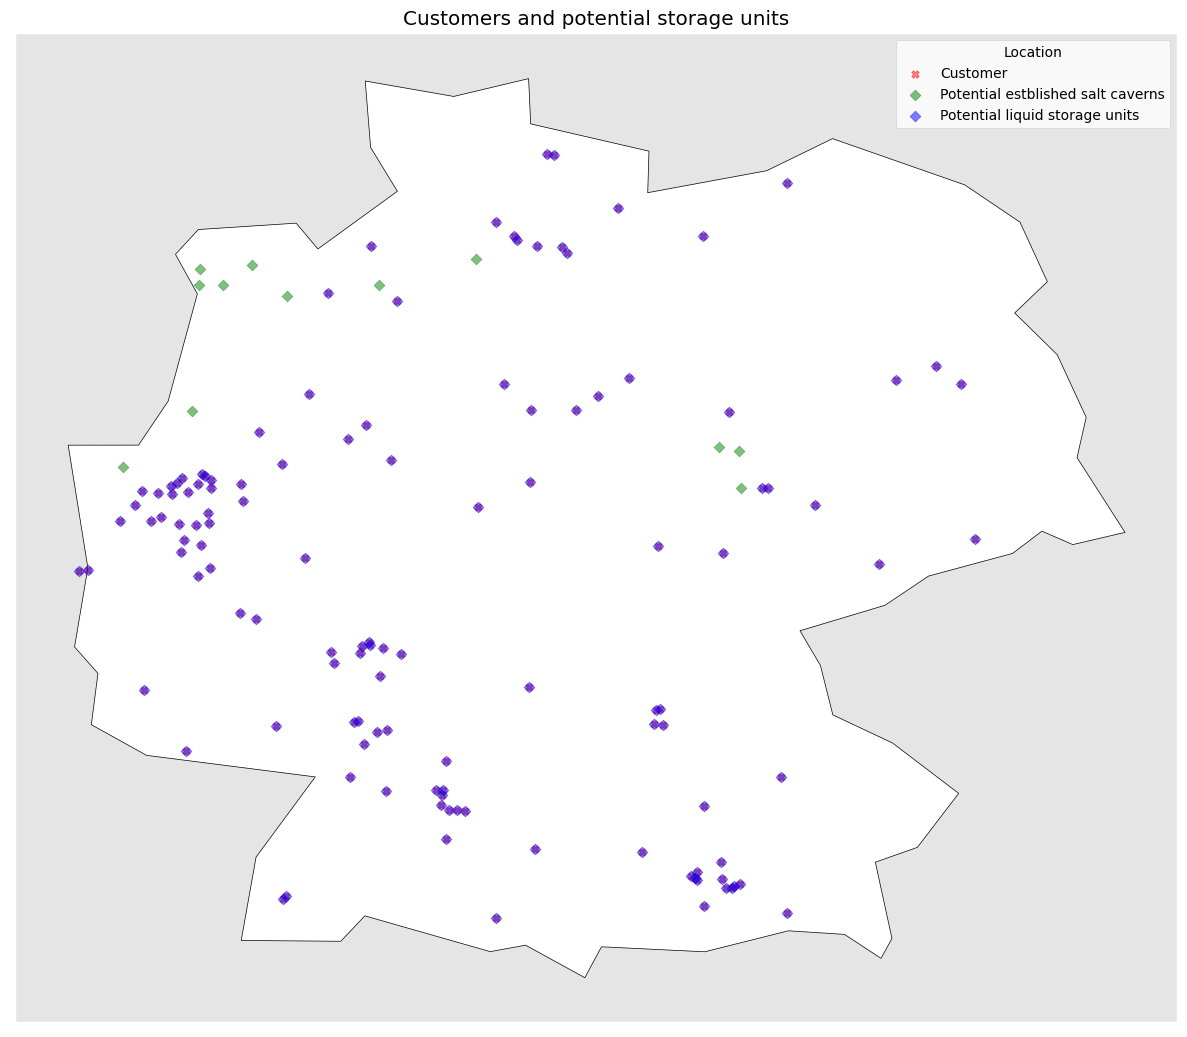

In [5]:
# Prepare country plot
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Extract and plot the shape of Germany
germany = world[world.name == 'Germany']
ax = germany.plot(color='white', edgecolor='black', figsize=(15, 15))

# Plot customers as points
customer_df.\
    plot(ax=ax, marker='X', color='red', markersize=30, alpha=0.5, label='Customer')

# Plot potential facility locations as points
salt_df.\
    plot(ax=ax, marker='D', color='green', markersize=30, alpha=0.5, label='Potential estblished salt caverns')

# Plot potential facility locations as points
facility_df.\
    plot(ax=ax, marker='D', color='blue', markersize=30, alpha=0.5, label='Potential liquid storage units')

# Add legend
plt.legend(facecolor='white', title='Location')

# Add title
plt.title('Customers and potential storage units')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

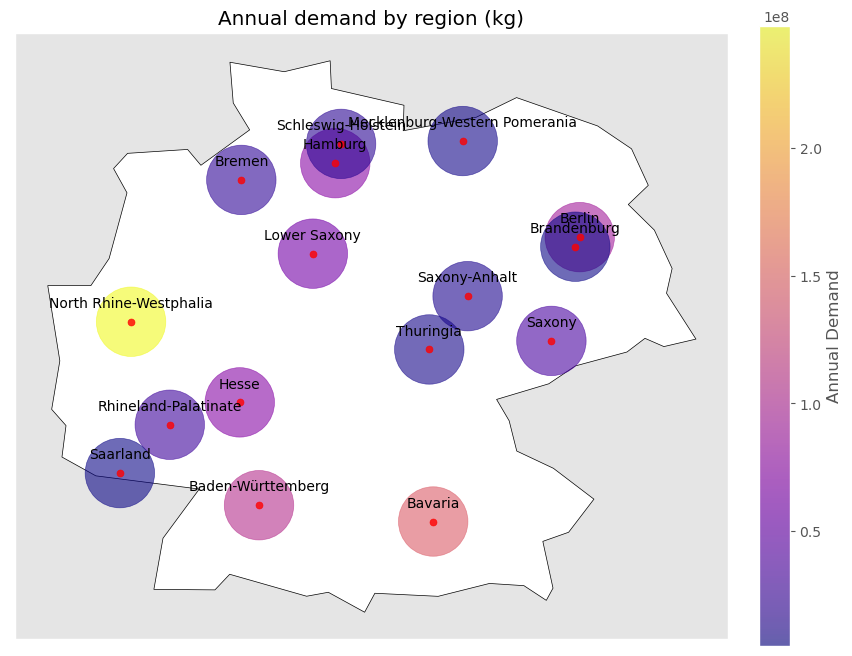

In [6]:
# Prepare region dataframe:
#   1. Filter the 16 regions of germany
#   2. Group by region
#   3. Calculate:
#      - Mean regional latitude
#      - Mean regional longitude
#      - Sum of regional demand
region_df = df.\
             loc[df.admin_name.isin(REGION_LIST)].\
             groupby(['admin_name']).\
             agg({'lat': 'mean', 'lng': 'mean', 'demand': 'sum'}).\
             reset_index()

# Add geo-coordinates
region_df = add_geocoordinates(region_df)

# Plot the shape of gemany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot region area colored based on demand
region_df.\
    plot(ax=ax, column='demand', marker='o', c='demand', cmap='plasma', markersize=2500, alpha=0.6)

# Add region 'center' as red dots
region_df.\
    plot(ax=ax, marker='o', c='red', markersize=25, alpha=0.8, label='Customer location')

# Add region name above the center
for i, row in region_df.iterrows():
    plt.annotate(
        row.admin_name, xy=(row.lng, row.lat+0.2), horizontalalignment='center')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Annual Demand', fraction=0.04, pad=0.04) 

# Add title
plt.title('Annual demand by region (kg)')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

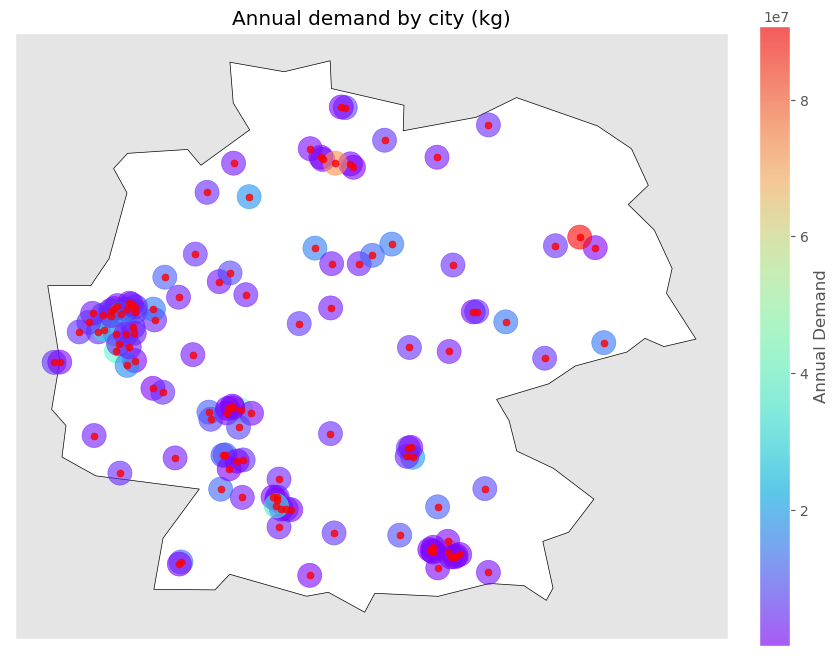

In [7]:
# Plot the shape of gemany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot region area colored based on demand
customer_df.\
    plot(ax=ax, column='demand', marker='o', c='demand', cmap='rainbow', markersize=300, alpha=0.6)

# Add region 'center' as red dots
customer_df.\
    plot(ax=ax, marker='o', c='red', markersize=25, alpha=0.8, label='Customer location')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Annual Demand', fraction=0.04, pad=0.04) 

# Add title
plt.title('Annual demand by city (kg)')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

In [8]:
# Dictionary of cutomer id (id) and demand (value)
demand_dict = { customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id']) }
print(demand_dict)

{1: 19077525.0, 2: 72957200.0, 3: 4842025.0, 4: 7948740.0, 5: 10753949.0, 6: 4783418.0, 7: 44006959.0, 8: 5426411.0, 9: 2035883.0, 10: 13005751.0, 11: 3653636.0, 12: 2340651.0, 13: 7647260.0, 14: 219680.0, 15: 2603713.0, 16: 154933.0, 17: 17565982.0, 18: 15033469.0, 19: 1056692.0, 20: 5767848.0, 21: 779785.0, 22: 681401.0, 23: 1491102.0, 24: 200100.0, 25: 1672903.0, 26: 5825371.0, 27: 2582118.0, 28: 5059383.0, 29: 1641632.0, 30: 332520.0, 31: 8243551.0, 32: 7218935.0, 33: 2743118.0, 34: 11114257.0, 35: 3595597.0, 36: 5018086.0, 37: 683849.0, 38: 1060496.0, 39: 14013124.0, 40: 39349935.0, 41: 2745293.0, 42: 2953463.0, 43: 3127332.0, 44: 4306168.0, 45: 3493031.0, 46: 1022688.0, 47: 3268308.0, 48: 11952231.0, 49: 456979.0, 50: 7418893.0, 51: 1026991.0, 52: 875728.0, 53: 2503028.0, 54: 5597878.0, 55: 5053563.0, 56: 832758.0, 57: 16397774.0, 58: 280778.0, 59: 13914457.0, 60: 2921409.0, 61: 2906444.0, 62: 6408058.0, 63: 31093170.0, 64: 2802809.0, 65: 1235364.0, 66: 3502698.0, 67: 6839141.0, 

In [9]:
city_demand = {}
total_demand = 0
for i, city in enumerate(customer_df['city']):
    if city in city_demand:
        city_demand[city] += customer_df['demand'][i]
    else:
        city_demand[city] = customer_df['demand'][i]
        
    total_demand += customer_df['demand'][i]


for city, demand in city_demand.items():
    print(f"City: {city}, Total Demand: {demand}")
    
print(total_demand)

City: Nuremberg, Total Demand: 19077525.0
City: Munich, Total Demand: 72957200.0
City: Gelsenkirchen, Total Demand: 4842025.0
City: Wuppertal, Total Demand: 7948740.0
City: Münster, Total Demand: 10753949.0
City: Potsdam, Total Demand: 4783418.0
City: Frankfurt, Total Demand: 44006959.0
City: Mönchengladbach, Total Demand: 5426411.0
City: Gladbeck, Total Demand: 2035883.0
City: Mannheim, Total Demand: 13005751.0
City: Reutlingen, Total Demand: 3653636.0
City: Schwerin, Total Demand: 2340651.0
City: Mainz, Total Demand: 7647260.0
City: Weißenthurm, Total Demand: 219680.0
City: Gütersloh, Total Demand: 2603713.0
City: Eichwalde, Total Demand: 154933.0
City: Bremen, Total Demand: 17565982.0
City: Hannover, Total Demand: 15033469.0
City: Kornwestheim, Total Demand: 1056692.0
City: Aachen, Total Demand: 5767848.0
City: Obertshausen, Total Demand: 779785.0
City: Ottobrunn, Total Demand: 681401.0
City: Hilden, Total Demand: 1491102.0
City: Altbach, Total Demand: 200100.0
City: Herten, Total D

In [10]:
COST_PER_KG = 18.2
SUPPLY_PER_WAREHOUSE = 3_150_000 * 2
TOTALCOST = COST_PER_KG * SUPPLY_PER_WAREHOUSE

# Warehouses list
facility_df['warehouse_id'] = ['Warehouse ' + str(i) for i in range(1, 1 + facility_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict_facility = { warehouse : SUPPLY_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict_facility = { warehouse : TOTALCOST for warehouse in facility_df['warehouse_id'] }

In [11]:
# Warehouses list
salt_df['salt_id'] = ['Salt cavern ' + str(i) for i in range(1, 1 + salt_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict_salt = { salt : salt_df['capacity_kg'][i] for i, salt in enumerate(salt_df['salt_id']) }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict_salt = { salt : salt_df['investment_costs'][i] for i, salt in enumerate(salt_df['salt_id']) }

In [12]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Calculate distance between two locations given latitude and longitude.

    Args:
       - lat1: latitude of the first location
       - lon1: longitude of the first location
       - lat2: latitude of the second location
       - lon2: longitude of the second location
    Out:
       - Distance in Km
    
    Ref: 
       - https://en.wikipedia.org/wiki/Haversine_formula
    '''
    return 6371.01 *\
            acos(sin(radians(lat1))*sin(radians(lat2)) +\
            cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))

In [13]:
def traveling_cost_truck(distance_in_km):
    '''
    Return traveling cost in euros given a distance in Km.

    Args:
      - distance_in_km: travel distance in Km
    Out:
      - cost of the trip in euros
    '''
    #done
    return 0.01 * distance_in_km + 0.18

In [14]:
def traveling_cost_pipeline(distance_in_km):
    '''
    Return traveling cost in euros given a distance in Km.

    Args:
      - distance_in_km: travel distance in Km
    Out:
      - cost of the trip in euros
    '''
    return  0.0001782 * distance_in_km

In [15]:

# Function to find the location of a specific city
def find_city_location(city_name, city_data):
    # Check if the city exists in the city database
    if city_name in city_data['city'].values:
        # Get the latitude and longitude values for the city
        city_row = city_data[city_data['city'] == city_name].iloc[0]
        city_lat = city_row['lat']
        city_lng = city_row['lng']

        # Find the closest node in the graph
        closest_node = None
        min_distance = float('inf')

        # Iterate over each node in the graph
        for node in G.nodes():
            # Get the latitude and longitude values for the node
            node_lat = G.nodes[node]['lat']
            node_lng = G.nodes[node]['long']

            # Calculate the distance between the node and the city using geopy
            node_location = (node_lat, node_lng)
            city_location = (city_lat, city_lng)
            node_distance = distance(node_location, city_location).km

            # Update the closest node if a shorter distance is found
            if node_distance < min_distance:
                min_distance = node_distance
                closest_node = node

        return closest_node
    else:
        return "no distance found"



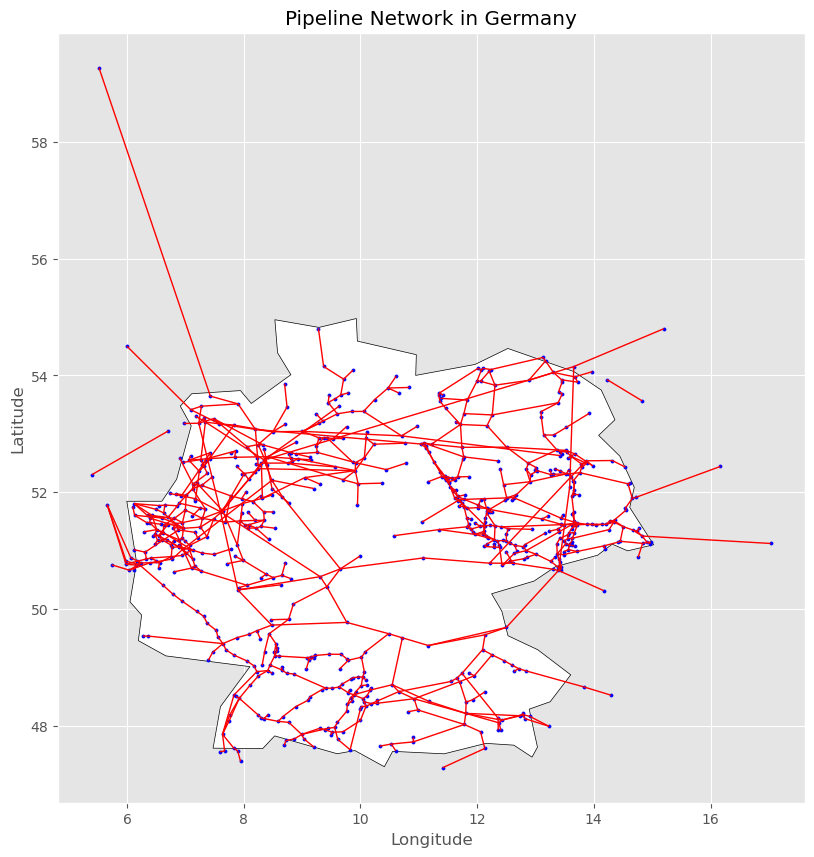

In [16]:
import geopandas as gpd

# Read the pipeline data from a CSV file
pipeline_data = pd.read_csv('LKD_PipeSegments.csv', delimiter=';', usecols=['name', 'node_id', 'lat', 'long'])

# Create an empty graph
G = nx.Graph()

# Iterate over each row in the pipeline data
for index, row in pipeline_data.iterrows():
    node_ids = row['node_id'][1:-1].split(', ')
    latitudes = row['lat'][1:-1].split(', ')
    longitudes = row['long'][1:-1].split(', ')

    # Iterate over each node ID, latitude, and longitude pair
    for i in range(len(node_ids)):
        node_id = node_ids[i][1:-1]  # Remove the square brackets from the node ID
        latitude = float(latitudes[i])
        longitude = float(longitudes[i])

        # Check if the node already exists in the graph
        if not G.has_node(node_id):
            # Add the node to the graph
            G.add_node(node_id)

        # Set latitude and longitude as node attributes
        G.nodes[node_id]['lat'] = latitude
        G.nodes[node_id]['long'] = longitude

        # Calculate the distance between the current node and the next node
        if i < len(node_ids) - 1:
            next_node_id = node_ids[i + 1][1:-1]  # Remove the square brackets from the next node ID
            next_latitude = float(latitudes[i + 1])
            next_longitude = float(longitudes[i + 1])

            # Calculate the distance between the current node and the next node using latitude and longitude
            node_distance = distance((latitude, longitude), (next_latitude, next_longitude)).kilometers

            # Add an edge between the current node and the next node with the distance as an attribute
            G.add_edge(node_id, next_node_id, distance=node_distance)

            # Create a GeoDataFrame from the node attributes in the graph
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index', columns=['lat', 'long'])
geometry = gpd.points_from_xy(nodes_df['long'], nodes_df['lat'])
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=geometry)

# Create a GeoDataFrame from the edges in the graph
edges_data = []
lines = []
for u, v, data in G.edges(data=True):
    source = nodes_gdf.loc[u, 'geometry']
    target = nodes_gdf.loc[v, 'geometry']
    line = LineString([source, target])
    lines.append(line)
    edges_data.append((u, v, data['distance']))

edges_df = pd.DataFrame(edges_data, columns=['source', 'target', 'distance'])
edges_gdf = gpd.GeoDataFrame(edges_df, geometry=lines)

# Plot the graph
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'] == 'Germany']
fig, ax = plt.subplots(figsize=(10, 10))
germany.plot(ax=ax, color='white', edgecolor='black')
edges_gdf.plot(ax=ax, color='red', linewidth=1)
nodes_gdf.plot(ax=ax, color='blue', markersize=5)
plt.title('Pipeline Network in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [17]:
def calculate_distance_pipeline(city1_name, database_1, city2_name, database_2):
    closest_node1 = find_city_location(city1_name, database_1)
    closest_node2 = find_city_location(city2_name, database_2)

    shortest_path = nx.shortest_path(G, closest_node1, closest_node2, weight='distance')

    total_distance = sum(G.edges[u, v]['distance'] for u, v in zip(shortest_path[:-1], shortest_path[1:]))

    return total_distance

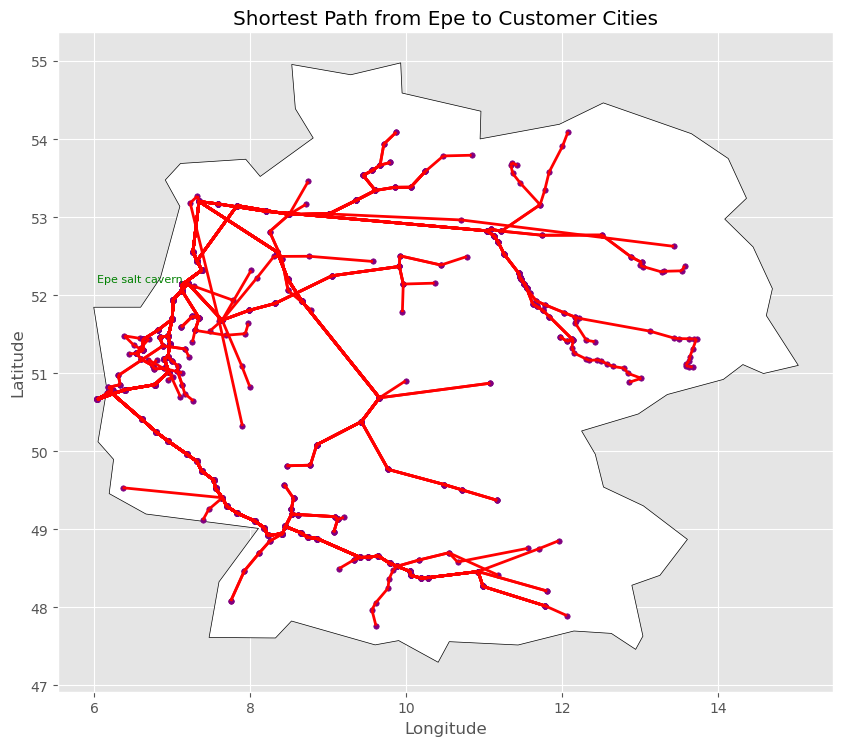

In [18]:
closest_node1 = find_city_location("Epe", salt_df)
customer_cities = customer_df['city'].tolist()

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the graph and nodes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'] == 'Germany']
germany.plot(ax=ax, color='white', edgecolor='black')

# Iterate over customer cities and plot shortest path from Epe
for city in customer_cities:
    closest_node2 = find_city_location(city, customer_df)
    shortest_path = nx.shortest_path(G, closest_node1, closest_node2, weight='distance')

    # Create a GeoDataFrame for the shortest path nodes
    path_nodes_data = []
    for node in shortest_path:
        geometry = nodes_gdf.loc[node, 'geometry']
        path_nodes_data.append({'geometry': geometry})

    path_nodes_gdf = gpd.GeoDataFrame(path_nodes_data)

    # Create a GeoDataFrame for the shortest path
    path_data = []
    path_lines = []
    for i in range(len(shortest_path) - 1):
        u = shortest_path[i]
        v = shortest_path[i + 1]
        data = G.edges[u, v]
        source = nodes_gdf.loc[u, 'geometry']
        target = nodes_gdf.loc[v, 'geometry']
        line = LineString([source, target])
        path_lines.append(line)
        path_data.append((u, v, data['distance']))

    path_df = pd.DataFrame(path_data, columns=['source', 'target', 'distance'])
    path_gdf = gpd.GeoDataFrame(path_df, geometry=path_lines)

    # Plot the shortest path nodes and path
    path_gdf.plot(ax=ax, color='red', linewidth=2)
    path_nodes_gdf.plot(ax=ax, color='purple', markersize=15)


    # Add city name to the plot
    city_node = nodes_gdf.loc[closest_node2, 'geometry']

# Add start city name to the plot
start_city_name = "Epe salt cavern"
start_node = nodes_gdf.loc[closest_node1, 'geometry']
ax.annotate(start_city_name, (start_node.x, start_node.y), color='green', fontsize=8, ha='right', va='bottom')

plt.title('Shortest Path from Epe to Customer Cities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [19]:
# # Dict to store the distances between all salt location and customers
# transport_costs_dict_salt = {}

# # For each warehouse location
# for i in range(0, salt_df.shape[0]):
    
#     # Dict to store the distances between the i-th salt location and all customers
#     warehouse_transport_costs_dict = {}
    
#     # For each customer location
#     for j in range(0, customer_df.shape[0]):
        
#         # Distance in Km between warehouse i and customer j
#         d = 0 if salt_df.city[i]==customer_df.city[j] else calculate_distance_pipeline(salt_df.city[i], salt_df, customer_df.city[j], customer_df)
        
#         # Update costs for warehouse i
#         warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost_pipeline(d)})
    
#     # Final dictionary with all costs for all warehouses
#     transport_costs_dict_salt.update({salt_df.salt_id[i]: warehouse_transport_costs_dict})

In [20]:
transport_costs_dict_salt = {'Salt cavern 1': {1: 0.11987210896984796, 2: 0.13991776336067566, 3: 0.013409301762968267, 4: 0.020803731269489638, 5: 0.00889969914185165, 6: 0.09447863378999896, 7: 0.09666268297559198, 8: 0.02131240398227466, 9: 0.013500490439133317, 10: 0.10103714351637198, 11: 0.10939089189141345, 12: 0.0913804585358833, 13: 0.10587835165500278, 14: 0.031097479350950166, 15: 0.023774718613386474, 16: 0.10357390027077203, 17: 0.03449722561967116, 18: 0.04793700958753716, 19: 0.10464343636400529, 20: 0.03415095672091509, 21: 0.09666268297559198, 22: 0.1427802678027167, 23: 0.01964613261888092, 24: 0.10481081591765294, 25: 0.013409301762968267, 26: 0.06531127434994365, 27: 0.05037730155917536, 28: 0.027805777827651798, 29: 0.013500490439133317, 30: 0.09666268297559198, 31: 0.14286696244531777, 32: 0.06304896150099981, 33: 0.03177887167987971, 34: 0.02440759504801789, 35: 0.05527294435755259, 36: 0.08320220531037983, 37: 0.1427802678027167, 38: 0.02662504784801547, 39: 0.12249718082931331, 40: 0.030343569818552768, 41: 0.057517929199114144, 42: 0.07287601587884877, 43: 0.09452679216833863, 44: 0.1025075162306075, 45: 0.01495048580174276, 46: 0.10113066347015866, 47: 0.023056976717287812, 48: 0.05537733320442019, 49: 0.05582089253141491, 50: 0.01223100639199675, 51: 0.05582089253141491, 52: 0.09666268297559198, 53: 0.022914779840458373, 54: 0.09724377617126027, 55: 0.027396535234952817, 56: 0.1282086593452029, 57: 0.02957429836074792, 58: 0.06304896150099981, 59: 0.10172867201833886, 60: 0.10464343636400529, 61: 0.10481081591765294, 62: 0.08661458391910853, 63: 0.025819060789274463, 64: 0.026139585110981464, 65: 0.10590407157975362, 66: 0.02976665464858312, 67: 0.11354755674455283, 68: 0.05994445033406739, 69: 0.039752517349790066, 70: 0.12722364319441187, 71: 0.10587835165500278, 72: 0.02289176143898354, 73: 0.11561413949576359, 74: 0.1427802678027167, 75: 0.05141369137273026, 76: 0.10464343636400529, 77: 0.1427802678027167, 78: 0.09666268297559198, 79: 0.11721926565183961, 80: 0.14723605959804612, 81: 0.021641807579475952, 82: 0.01495048580174276, 83: 0.07948933646255056, 84: 0.015224128956094927, 85: 0.10737294647834816, 86: 0.05624521300487796, 87: 0.13109083281712708, 88: 0.10196758502237614, 89: 0.01758375569658549, 90: 0.10113066347015866, 91: 0.11987210896984796, 92: 0.08316809737523619, 93: 0.13648035957973076, 94: 0.09666268297559198, 95: 0.08957990929628065, 96: 0.1427802678027167, 97: 0.08988993646538425, 98: 0.05624521300487796, 99: 0.09072048623861799, 100: 0.05624521300487796, 101: 0.01223100639199675, 102: 0.09764592353778809, 103: 0.10103714351637198, 104: 0.13109083281712708, 105: 0.09881866572409309, 106: 0.09450866443098062, 107: 0.11987210896984796, 108: 0.03415095672091509, 109: 0.10737294647834816, 110: 0.13991776336067566, 111: 0.09724377617126027, 112: 0.13109083281712708, 113: 0.10021751595593421, 114: 0.013500490439133317, 115: 0.01994641855084219, 116: 0.09881866572409309, 117: 0.05411601399867301, 118: 0.1314269630910196, 119: 0.10590407157975362, 120: 0.013409301762968267, 121: 0.05744656526877519, 122: 0.032937092534190325}, 'Salt cavern 2': {1: 0.11421129902558426, 2: 0.13252504366052495, 3: 0.016286643325067744, 4: 0.012293633594485069, 5: 0.023176861500693726, 6: 0.11001102179405417, 7: 0.0950509790503287, 8: 0.014295379610880003, 9: 0.007890383489347638, 10: 0.09364442381622128, 11: 0.10199817219126271, 12: 0.1069128465399385, 13: 0.10410424659657411, 14: 0.02408466350195319, 15: 0.026757291842738735, 16: 0.11910628827482724, 17: 0.0500296136237264, 18: 0.05091958281688943, 19: 0.09725071666385457, 20: 0.02564085904591051, 21: 0.0950509790503287, 22: 0.13538754810256598, 23: 0.012253412918730208, 24: 0.0974180962175022, 25: 0.016286643325067744, 26: 0.08084366235399888, 27: 0.053359874788527606, 28: 0.030788351057004056, 29: 0.007890383489347638, 30: 0.0950509790503287, 31: 0.13547424274516706, 32: 0.07858134950505506, 33: 0.03476144490923198, 34: 0.01739057067662323, 35: 0.05825551758690484, 36: 0.09873459331443506, 37: 0.13538754810256598, 38: 0.019612231999018494, 39: 0.13802956883336853, 40: 0.02332654544715811, 41: 0.060500502428466385, 42: 0.06548329617869807, 43: 0.08713407246818791, 44: 0.09511479653045678, 45: 0.006440388126738195, 46: 0.1166630514742139, 47: 0.023176038229032192, 48: 0.05835990643377244, 49: 0.07135328053547015, 50: 0.012350067903741133, 51: 0.07135328053547015, 52: 0.0950509790503287, 53: 0.014404682165453804, 54: 0.08985105647110957, 55: 0.020003815534802107, 56: 0.12081593964505218, 57: 0.022181578660597213, 58: 0.07858134950505506, 59: 0.11726106002239407, 60: 0.09725071666385457, 61: 0.0974180962175022, 62: 0.08500287999384526, 63: 0.018802036417879805, 64: 0.015112722032831902, 65: 0.09851135187960289, 66: 0.022749630277188463, 67: 0.10788674680028915, 68: 0.06292702356341963, 69: 0.0552849053538453, 70: 0.11983092349426115, 71: 0.10410424659657411, 72: 0.015499041738832832, 73: 0.10822141979561288, 74: 0.13538754810256598, 75: 0.0669460793767855, 76: 0.09725071666385457, 77: 0.13538754810256598, 78: 0.0950509790503287, 79: 0.13275165365589484, 80: 0.1398433398978954, 81: 0.014624783208081294, 82: 0.006440388126738195, 83: 0.07209661676239985, 84: 0.012347727431940979, 85: 0.09998022677819746, 86: 0.0717776010089332, 87: 0.12369811311697639, 88: 0.10019347996394747, 89: 0.016422513498107232, 90: 0.1166630514742139, 91: 0.11421129902558426, 92: 0.09203349753113775, 93: 0.12908763987958005, 94: 0.0950509790503287, 95: 0.08218718959612994, 96: 0.13538754810256598, 97: 0.08249721676523354, 98: 0.0717776010089332, 99: 0.10625287424267323, 100: 0.0717776010089332, 101: 0.012350067903741133, 102: 0.11317831154184331, 103: 0.09364442381622128, 104: 0.12369811311697639, 105: 0.09720696179882982, 106: 0.08711594473082991, 107: 0.11421129902558426, 108: 0.02564085904591051, 109: 0.09998022677819746, 110: 0.13252504366052495, 111: 0.08985105647110957, 112: 0.12369811311697639, 113: 0.09455670601167053, 114: 0.007890383489347638, 115: 0.013193982579075473, 116: 0.09720696179882982, 117: 0.06964840200272825, 118: 0.12403424339086888, 119: 0.09851135187960289, 120: 0.016286643325067744, 121: 0.07297895327283042, 122: 0.04846948053824556}, 'Salt cavern 3': {1: 0.10423357716908804, 2: 0.13330116529797534, 3: 0.04790652738263942, 4: 0.05530095688916079, 5: 0.0433969247615228, 6: 0.06883922230563659, 7: 0.08102415117483208, 8: 0.05580962960194582, 9: 0.04799771605880447, 10: 0.09287810936934243, 11: 0.12352627184635938, 12: 0.06574104705152092, 13: 0.09023981985424288, 14: 0.06559470497062132, 15: 0.050583575359976665, 16: 0.07793448878640967, 17: 0.0, 18: 0.05352323842729265, 19: 0.11207277230342044, 20: 0.06864818234058624, 21: 0.08102415117483208, 22: 0.1365556064144647, 23: 0.054143358238552076, 24: 0.11894619587259887, 25: 0.04790652738263942, 26: 0.0380973714542476, 27: 0.033006129819278446, 28: 0.057290024156671275, 29: 0.04799771605880447, 30: 0.08102415117483208, 31: 0.13324930009841912, 32: 0.035835058605303775, 33: 0.06627609729955086, 34: 0.05890482066768904, 35: 0.03790177261765568, 36: 0.05756279382601746, 37: 0.1365556064144647, 38: 0.06112227346768663, 39: 0.09685776934495088, 40: 0.06484079543822391, 41: 0.04014675745921723, 42: 0.0906808234571412, 43: 0.10866217212328456, 44: 0.10993685217002265, 45: 0.049447711421413916, 46: 0.0754912519857963, 47: 0.05755420233695895, 48: 0.03259182803598707, 49: 0.028606989635718873, 50: 0.0467282320116679, 51: 0.028606989635718873, 52: 0.08102415117483208, 53: 0.05741200546012953, 54: 0.09667147671445414, 55: 0.06189376085462397, 56: 0.13410704015059624, 57: 0.06407152398041907, 58: 0.035835058605303775, 59: 0.07608926053397648, 60: 0.11207277230342044, 61: 0.11894619587259887, 62: 0.07909179263487717, 63: 0.06031628640894562, 64: 0.06063681073065262, 65: 0.12003945153469955, 66: 0.06426388026825428, 67: 0.09790902494379293, 68: 0.03715894516563426, 69: 0.012538614454094037, 70: 0.12099898180615988, 71: 0.09023981985424288, 72: 0.057388987058654695, 73: 0.12151252030115693, 74: 0.1365556064144647, 75: 0.024199788477034224, 76: 0.11207277230342044, 77: 0.1365556064144647, 78: 0.08102415117483208, 79: 0.09157985416747724, 80: 0.1410113982097941, 81: 0.056139033199147106, 82: 0.049447711421413916, 83: 0.09729414404084298, 84: 0.04972135457576607, 85: 0.12517775405664056, 86: 0.02903131010918192, 87: 0.1248661714288751, 88: 0.08632905322161624, 89: 0.052080981316256644, 90: 0.0754912519857963, 91: 0.10423357716908804, 92: 0.06413062210470151, 93: 0.1290679015090637, 94: 0.08102415117483208, 95: 0.10738471687457309, 96: 0.1365556064144647, 97: 0.10402531642033018, 98: 0.02903131010918192, 99: 0.06350658334292196, 100: 0.02903131010918192, 101: 0.0467282320116679, 102: 0.0720065120534257, 103: 0.09287810936934243, 104: 0.1248661714288751, 105: 0.09129587443986172, 106: 0.0994065884547338, 107: 0.10423357716908804, 108: 0.06864818234058624, 109: 0.12517775405664056, 110: 0.13330116529797534, 111: 0.09667147671445414, 112: 0.1248661714288751, 113: 0.08457898415517431, 114: 0.04799771605880447, 115: 0.054443644170513346, 116: 0.09129587443986172, 117: 0.02690211110297698, 118: 0.12401450502035254, 119: 0.12003945153469955, 120: 0.04790652738263942, 121: 0.030232662373079148, 122: 0.007297681049827954}, 'Salt cavern 4': {1: 0.10075246370890129, 2: 0.12982005183778858, 3: 0.04090486032491939, 4: 0.04829928983144075, 5: 0.03639525770380277, 6: 0.0712768836904175, 7: 0.07754303771464531, 8: 0.048807962544225786, 9: 0.040996049001084445, 10: 0.08939699590915566, 11: 0.12004515838617262, 12: 0.06817870843630183, 13: 0.08675870639405613, 14: 0.05859303791290129, 15: 0.0512702771753376, 16: 0.08037215017119058, 17: 0.017033023484436808, 18: 0.06176446216057615, 19: 0.10859165884323367, 20: 0.06164651528286621, 21: 0.07754303771464531, 22: 0.13307449295427798, 23: 0.047141691180832036, 24: 0.11546508241241212, 25: 0.04090486032491939, 26: 0.04784707221470928, 27: 0.041247353552561934, 28: 0.05530133638960292, 
29: 0.040996049001084445, 30: 0.07754303771464531, 31: 0.12976818663823236, 32: 0.045584759365765455, 33: 0.05927443024183084, 34: 0.051903153609969006, 35: 0.046142996350939165, 36: 0.060000455210798366, 37: 0.13307449295427798, 38: 0.05412060640996659, 39: 0.09929543072973179, 40: 0.05783912838050388, 41: 0.04838798119250071, 42: 0.08719970999695445, 43: 0.1051810586630978, 44: 0.10645573870983588, 45: 0.04244604436369388, 46: 0.07792891337057721, 47: 0.05055253527923893, 48: 0.04083305176927056, 49: 0.03835669039618055, 50: 0.03972656495394787, 51: 0.03835669039618055, 52: 0.07754303771464531, 53: 0.05041033840240949, 54: 0.09319036325426738, 55: 0.054892093796903935, 56: 0.13062592669040946, 57: 0.05706985692269904, 58: 0.045584759365765455, 59: 0.07852692191875739, 60: 0.10859165884323367, 61: 0.11546508241241212, 62: 0.06927285483705739, 63: 0.053314619351225584, 64: 0.05363514367293258, 65: 0.1165583380745128, 66: 0.05726221321053424, 67: 0.09442791148360617, 68: 0.04540016889891775, 69: 0.022288315214555716, 70: 0.11751786834597314, 71: 0.08675870639405613, 72: 0.05038732000093466, 73: 0.11803140684097016, 74: 0.13307449295427798, 75: 0.029422254340708314, 76: 0.10859165884323367, 77: 0.13307449295427798, 78: 0.07754303771464531, 79: 0.09401751555225817, 80: 0.13753028474960738, 81: 0.049137366141427066, 82: 0.04244604436369388, 83: 0.09381303058065622, 84: 0.04271968751804605, 85: 0.12169664059645378, 86: 0.038781010869643605, 87: 0.12138505796868836, 88: 0.08284793976142948, 89: 0.04507931425853662, 90: 0.07792891337057721, 91: 0.10075246370890129, 92: 0.06064950864451476, 93: 0.12558678804887694, 94: 0.07754303771464531, 95: 0.10390360341438633, 96: 0.13307449295427798, 97: 0.10054420296014341, 98: 0.038781010869643605, 99: 0.07325628410338364, 100: 0.038781010869643605, 101: 0.03972656495394787, 102: 0.07444417343820661, 103: 0.08939699590915566, 104: 0.12138505796868836, 105: 0.08147693664204193, 106: 0.09592547499454704, 107: 0.10075246370890129, 108: 0.06164651528286621, 109: 0.12169664059645378, 110: 0.12982005183778858, 111: 0.09319036325426738, 112: 0.12138505796868836, 113: 0.08109787069498756, 114: 0.040996049001084445, 115: 0.04744197711279331, 116: 0.08147693664204193, 117: 0.03665181186343866, 118: 0.12053339156016578, 119: 0.1165583380745128, 120: 0.04090486032491939, 121: 0.035455128236753244, 122: 0.009735342434608857}, 'Salt cavern 5': {1: 0.12020489720196625, 2: 0.14927248533085355, 3: 0.06387784741551762, 4: 0.071272276922039, 5: 0.059368244794401004, 6: 0.0848105423385148, 7: 0.09699547120771028, 8: 0.07178094963482402, 9: 0.06396903609168268, 10: 0.10884942940222063, 11: 0.13949759187923758, 12: 0.08171236708439913, 13: 0.10621113988712108, 14: 0.08156602500349953, 15: 0.054407353489360606, 16: 0.09390580881928787, 17: 0.023254642756853332, 18: 0.05734701655667661, 19: 0.12804409233629863, 20: 0.08461950237346445, 21: 0.09699547120771028, 22: 0.15252692644734295, 23: 0.07011467827143028, 24: 0.13491751590547707, 25: 0.06387784741551762, 26: 0.023354048652275063, 27: 0.036829907948662394, 28: 0.06111380228605522, 29: 0.06396903609168268, 30: 0.09699547120771028, 31: 0.1492206201312973, 32: 0.012580415848450452, 33: 0.07847743052646401, 34: 0.07487614070056725, 35: 0.041725550747039625, 36: 0.07353411385889566, 37: 0.15252692644734295, 38: 0.07709359350056483, 39: 0.11282908937782914, 40: 0.08081211547110212, 41: 0.04397053558860118, 42: 0.10665214349001943, 43: 0.12463349215616278, 44: 0.12590817220290085, 45: 0.06541903145429212, 46: 0.0914625720186745, 47: 0.07352552236983716, 48: 0.03641560616537102, 49: 0.005352346878865545, 50: 0.0626995520445461, 51: 0.005352346878865545, 52: 0.09699547120771028, 53: 0.07338332549300773, 54: 0.11264279674733234, 55: 0.07786508088750217, 56: 0.15007836018347442, 57: 0.08004284401329728, 58: 0.012580415848450452, 59: 0.09206058056685469, 60: 0.12804409233629863, 61: 0.13491751590547707, 62: 0.09506311266775536, 63: 0.07628760644182382, 64: 0.07660813076353082, 65: 0.13601077156757777, 66: 0.08023520030113249, 67: 0.11388034497667114, 68: 0.04098272329501821, 69: 0.028509934486972238, 70: 0.1369703018390381, 71: 0.10621113988712108, 72: 0.0733603070915329, 73: 0.13748384033403513, 74: 0.15252692644734295, 75: 0.04017110850991243, 76: 0.12804409233629863, 77: 0.15252692644734295, 78: 0.09699547120771028, 79: 0.10755117420035544, 80: 0.15698271824267235, 81: 0.07211035323202532, 82: 0.06541903145429212, 83: 0.11326546407372123, 84: 0.06569267460864428, 85: 0.1411490740895188, 86: 0.014287987307209385, 87: 0.1408374914617533, 88: 0.10230037325449444, 89: 0.06703058289481101, 90: 0.0914625720186745, 91: 0.12020489720196625, 92: 0.0801019421375797, 93: 0.1450392215419419, 94: 0.09699547120771028, 95: 0.12335603690745132, 96: 0.15252692644734295, 97: 0.11999663645320838, 98: 0.014287987307209385, 99: 0.05449636441089878, 100: 0.014287987307209385, 101: 0.0626995520445461, 102: 0.08797783208630391, 103: 0.10884942940222063, 104: 0.1408374914617533, 105: 0.10726719447273993, 106: 0.11537790848761201, 107: 0.12020489720196625, 108: 0.08461950237346445, 109: 0.1411490740895188, 110: 0.14927248533085355, 111: 0.11264279674733234, 112: 0.1408374914617533, 113: 0.10055030418805253, 114: 0.06396903609168268, 115: 0.07041496420339155, 116: 0.10726719447273993, 117: 0.0036474683461236515, 118: 0.13998582505323073, 119: 0.13601077156757777, 120: 0.06387784741551762, 121: 0.046203982405957356, 122: 0.023269001082706155}, 'Salt cavern 6': {1: 0.10336218933739529, 2: 0.13242977746628257, 3: 0.035982358791108365, 4: 0.043376788297629726, 5: 0.03147275616999174, 6: 0.072108693140016, 7: 0.08015276334313931, 8: 0.04388546101041475, 9: 0.03607354746727341, 10: 0.09200672153764966, 11: 0.12265488401466661, 12: 0.06901051788590032, 13: 0.08936843202255013, 14: 0.05367053637909026, 15: 0.04634777564152656, 16: 0.08120395962078907, 17: 0.011924168591531063, 18: 0.058164084294848595, 19: 0.11120138447172767, 20: 0.05672401374905516, 21: 0.08015276334313931, 22: 0.13568421858277196, 23: 0.04221918964702101, 24: 0.1180748080409061, 25: 0.035982358791108365, 26: 0.042738217321803544, 27: 0.03764697568683438, 28: 0.050378834855791886, 29: 0.03607354746727341, 30: 0.08015276334313931, 31: 0.13237791226672635, 32: 0.04047590447285971, 33: 0.0543519287080198, 34: 0.04698065207615798, 35: 0.04254261848521161, 36: 0.06083226466039685, 37: 0.13568421858277196, 38: 0.04919810487615556, 39: 0.1001272401793303, 40: 0.052916626846692856, 41: 0.04478760332677316, 42: 0.09232532790892259, 43: 0.1077907842915918, 44: 0.10906546433832988, 45: 0.03752354282988285, 46: 0.0787607228201757, 47: 0.0456300337454279, 48: 0.037232673903543005, 49: 0.03324783550327481, 50: 0.034804063420136845, 51: 0.03324783550327481, 52: 0.08015276334313931, 53: 0.04548783686859846, 54: 0.09580008888276137, 55: 0.04996959226309291, 56: 0.13323565231890344, 57: 0.05214735538888801, 58: 0.04047590447285971, 59: 0.07935873136835588, 60: 0.11120138447172767, 61: 0.1180748080409061, 62: 0.07010466428665588, 63: 0.048392117817414565, 64: 0.04871264213912156, 65: 0.11916806370300678, 66: 0.052339711676723216, 67: 0.09703763711210017, 68: 0.041799791033190196, 69: 0.017179460321649968, 70: 0.12012759397446714, 71: 0.08936843202255013, 72: 0.04546481846712363, 73: 0.12064113246946415, 74: 0.13568421858277196, 75: 0.02884063434459016, 76: 0.11120138447172767, 77: 0.13568421858277196, 78: 0.08015276334313931, 79: 0.09484932500185665, 80: 0.14014001037810137, 81: 0.04421486460761605, 82: 0.03752354282988285, 83: 0.09893864849262439, 84: 0.03779718598423502, 85: 0.12453487139544824, 86: 0.03367215597673786, 87: 0.12399478359718236, 88: 0.08545766538992347, 89: 0.040156812724725585, 90: 0.0787607228201757, 91: 0.10336218933739529, 92: 0.0657751265564829, 93: 0.12819651367737095, 94: 0.08015276334313931, 95: 0.10902922132635448, 96: 0.13568421858277196, 97: 0.10315392858863741, 98: 0.03367215597673786, 99: 0.06814742921047791, 100: 0.03367215597673786, 101: 0.034804063420136845, 102: 0.07527598288780511, 103: 0.09200672153764966, 104: 0.12399478359718236, 105: 0.08230874609164043, 106: 0.09853520062304104, 107: 0.10336218933739529, 108: 0.05672401374905516, 109: 0.12453487139544824, 110: 0.13242977746628257, 111: 0.09580008888276137, 112: 0.12399478359718236, 113: 0.08370759632348156, 114: 0.03607354746727341, 115: 0.04251947557898228, 116: 0.08230874609164043, 117: 0.031542956970532915, 118: 0.12314311718865978, 119: 0.11916806370300678, 120: 0.035982358791108365, 121: 0.034873508240635086, 122: 0.010567151884207347}, 'Salt cavern 7': {1: 0.09745346514784682, 2: 0.1265210532767341, 3: 0.03582794558496941, 4: 0.04322237509149078, 5: 0.031318342963852795, 6: 0.07205998996799784, 7: 0.07424403915359085, 8: 0.04373104780427581, 9: 0.03591913426113446, 10: 0.08609799734810118, 11: 0.11674615982511813, 12: 0.06896181471388216, 13: 0.08345970783300166, 14: 0.05351612317295131, 15: 0.046193362435387623, 16: 0.0811552564487709, 17: 0.017816129762017133, 18: 0.06405604546533467, 19: 0.10529266028217919, 20: 0.05656960054291623, 21: 0.07424403915359085, 22: 0.1297754943932235, 23: 0.042064776440882065, 24: 0.11216608385135761, 25: 0.03582794558496941, 26: 0.04863017849228961, 27: 0.04353893685732045, 28: 0.05022442164965294, 29: 0.03591913426113446, 30: 0.07424403915359085, 31: 0.12646918807717789, 32: 0.04636786564334578, 33: 0.054197515501880865, 34: 0.046826238870019035, 35: 0.04843457965569768, 36: 0.06078356148837868, 37: 0.1297754943932235, 38: 0.04904369167001661, 39: 0.10007853700731212, 40: 0.05276221364055391, 41: 0.05067956449725924, 42: 0.08729965490567473, 43: 0.10188206010204331, 44: 0.1031567401487814, 45: 0.037369129623743905, 46: 0.07871201964815752, 47: 0.045475620539288955, 48: 0.043124635074029076, 49: 0.03913979667376088, 50: 0.03464965021399789, 51: 0.03913979667376088, 52: 0.07424403915359085, 53: 0.045333423662459515, 54: 0.08989136469321289, 55: 0.049815179056953963, 56: 0.12732692812935498, 57: 0.051992942182749066,
58: 0.04636786564334578, 59: 0.0793100281963377, 60: 0.10529266028217919, 61: 0.11216608385135761, 62: 0.0641959400971074, 63: 0.04823770461127561, 64: 0.04855822893298261, 65: 0.1132593395134583, 66: 0.05218529847058427, 67: 0.09112891292255171, 68: 0.047691752203676274, 69: 0.023071421492136042, 70: 0.11421886978491866, 71: 0.08345970783300166, 72: 0.04531040526098468, 73: 0.11473240827991568, 74: 0.1297754943932235, 75: 0.034499169080658296, 76: 0.10529266028217919, 77: 0.1297754943932235, 78: 0.07424403915359085, 79: 0.09480062182983849, 80: 0.1342312861885529, 81: 0.0440604514014771, 82: 0.037369129623743905, 83: 0.09391297548937651, 84: 0.03764277277809607, 85: 0.11862614720589977, 86: 0.03956411714722393, 87: 0.11808605940763388, 88: 0.079548941200375, 89: 0.04000239951858663, 90: 0.07871201964815752, 91: 0.09745346514784682, 92: 0.060749453553235036, 93: 0.12228778948782247, 94: 0.07424403915359085, 95: 0.10400354832310661, 96: 0.1297754943932235, 97: 0.09724520439908892, 98: 0.03956411714722393, 99: 0.07403939038096397, 100: 0.03956411714722393, 101: 0.03464965021399789, 102: 0.07522727971578694, 103: 0.08609799734810118, 104: 0.11808605940763388, 105: 0.07640002190209196, 106: 0.09262647643349255, 107: 0.09745346514784682, 108: 0.05656960054291623, 109: 0.11862614720589977, 110: 0.1265210532767341, 111: 0.08989136469321289, 112: 0.11808605940763388, 113: 0.07779887213393309, 114: 0.03591913426113446, 115: 0.04236506237284333, 116: 0.07640002190209196, 117: 0.037434918141018986, 118: 0.1172343929991113, 119: 0.1132593395134583, 120: 0.03582794558496941, 121: 0.04053204297670322, 122: 0.010518448712189179}, 'Salt cavern 8': {1: 0.10561484870808385, 2: 0.13468243683697115, 3: 0.04632817171463594, 4: 0.053722601221157316, 5: 0.041818569093519324, 6: 0.07670019508013405, 7: 0.08240542271382788, 8: 0.054231273933942344, 9: 0.046419360390800996, 10: 0.09425938090833823, 11: 0.12490754338535517, 12: 0.07360201982601837, 13: 0.09162109139323868, 14: 0.06401634930261785, 15: 0.05669358856505416, 16: 0.08579546156090712, 17: 0.022456334874153366, 18: 0.06869625057747089, 19: 0.11345404384241625, 20: 0.06706982667258277, 21: 0.08240542271382788, 22: 0.13793687795346052, 23: 0.0525650025705486, 24: 0.12032746741159467, 25: 0.04632817171463594, 26: 0.05327038360442584, 27: 0.04817914196945668, 28: 0.06072464777931947, 29: 0.046419360390800996, 30: 0.08240542271382788, 31: 0.1346305716374149, 32: 0.05100807075548202, 33: 0.06469774163154739, 34: 0.057326464999685564, 35: 0.053074784767833914, 36: 0.06542376660051491, 37: 0.13793687795346052, 38: 0.05954391779968315, 39: 0.10471874211944837, 40: 0.06326243977022043, 41: 0.05531976960939547, 42: 0.09206209499613699, 43: 0.11004344366228036, 44: 0.11131812370901846, 45: 0.04786935575341044, 46: 0.08335222476029375, 47: 0.055975846668955484, 48: 0.047764840186165315, 49: 0.0437800017858971, 50: 0.04514987634366442, 51: 0.0437800017858971, 52: 0.08240542271382788, 53: 0.05583364979212605, 54: 0.09805274825344994, 55: 0.06031540518662049, 56: 0.13548831168959202, 57: 0.062493168312415595, 58: 0.05100807075548202, 59: 0.08395023330847394, 60: 0.11345404384241625, 61: 0.12032746741159467, 62: 0.07469616622677394, 63: 0.05873793074094214, 64: 0.05905845506264914, 65: 0.12142072307369535, 66: 0.0626855246002508, 67: 0.09929029648278873, 68: 0.052331957315812506, 69: 0.02771162660427227, 70: 0.12238025334515568, 71: 0.09162109139323868, 72: 0.05581063139065122, 73: 0.12289379184015273, 74: 0.13793687795346052, 75: 0.03913937419279453, 76: 0.11345404384241625, 77: 0.13793687795346052, 78: 0.08240542271382788, 79: 0.0994408269419747, 80: 0.14239266974878992, 81: 0.05456067753114363, 82: 0.04786935575341044, 83: 0.09867541557983878, 84: 0.04814299890776261, 85: 0.1265590255956363, 86: 0.04420432225936016, 87: 0.12624744296787088, 88: 0.08771032476061204, 89: 0.05050262564825317, 90: 0.08335222476029375, 91: 0.10561484870808385, 92: 0.06551189364369729, 93: 0.1304491730480595, 94: 0.08240542271382788, 95: 0.10876598841356887, 96: 0.13793687795346052, 97: 0.10540658795932598, 98: 0.04420432225936016, 99: 0.07867959549310019, 100: 0.04420432225936016, 101: 0.04514987634366442, 102: 0.07986748482792316, 103: 0.09425938090833823, 104: 0.12624744296787088, 105: 0.0869002480317585, 106: 0.1007878599937296, 107: 0.10561484870808385, 108: 0.06706982667258277, 109: 0.1265590255956363, 110: 0.13468243683697115, 111: 0.09805274825344994, 112: 0.12624744296787088, 113: 0.08596025569417012, 114: 0.046419360390800996, 115: 0.05286528850250987, 116: 0.0869002480317585, 117: 0.04207512325315521, 118: 0.12539577655934833, 119: 0.12142072307369535, 120: 0.04632817171463594, 121: 0.045172248088839455, 122: 0.015158653824325411}, 'Salt cavern 9': {1: 0.09734063586102817, 2: 0.12640822398991547, 3: 0.039339718341562815, 4: 0.046734147848084176, 5: 0.0348301157204462, 6: 0.07468871153829063, 7: 0.0741312098667722, 8: 0.0472428205608692, 9: 0.03943090701772786, 10: 0.08598516806128254, 11: 0.11663333053829948, 12: 0.07159053628417496, 13: 0.08334687854618301, 14: 0.057027895929544714, 15: 0.049705135191981026, 16: 0.08378397801906369, 17: 0.020444851332309933, 18: 0.06517629000844927, 19: 0.10517983099536055, 20: 0.060081373299509626, 21: 0.0741312098667722, 22: 0.12966266510640484, 23: 0.04557654919747547, 24: 0.11205325456453896, 25: 0.039339718341562815, 26: 0.051258900062582415, 27: 0.04465918140043505, 28: 0.05373619440624634, 29: 0.03943090701772786, 30: 0.0741312098667722, 31: 0.12635635879035922, 32: 0.04899658721363858, 33: 0.05770928825847427, 34: 0.05033801162661243, 35: 0.04955482419881228, 36: 0.06341228305867148, 37: 0.12966266510640484, 38: 0.052555464426610014, 39: 0.10270725857760493, 40: 0.0562739863971473, 41: 0.05179980904037384, 42: 0.08378788214908132, 43: 0.10176923081522467, 44: 0.10304391086196275, 45: 0.04088090238033731, 46: 0.08134074121845032, 47: 0.04898739329588236, 48: 0.04424487961714368, 49: 0.04176851824405368, 50: 0.038161422970591295, 51: 0.04176851824405368, 52: 0.0741312098667722, 53: 0.04884519641905291, 54: 0.08977853540639424, 55: 0.053326951813547366, 56: 0.12721409884253634, 57: 0.05550471493934247, 58: 0.04899658721363858, 59: 0.08193874976663051, 60: 0.10517983099536055, 61: 0.11205325456453896, 62: 0.06770771285370081, 63: 0.05174947736786901, 64: 0.052070001689576005, 65: 0.11314651022663964, 66: 0.05569707122717766, 67: 0.09101608363573306, 68: 0.048811996746790876, 69: 0.02570014306242884, 70: 0.11410604049810001, 71: 0.08334687854618301, 72: 0.04882217801757809, 73: 0.11461957899309703, 74: 0.12966266510640484, 75: 0.032834082188581436, 76: 0.10517983099536055, 77: 0.12966266510640484, 78: 0.0741312098667722, 79: 0.09742934340013129, 80: 0.13411845690173427, 81: 0.04757222415807049, 82: 0.04088090238033731, 83: 0.09040120273278311, 84: 0.041154545534689474, 85: 0.11828481274858066, 86: 0.04219283871751673, 87: 0.11797323012081523, 88: 0.07943611191355636, 89: 0.043514172275180035, 90: 0.08134074121845032, 91: 0.09734063586102817, 92: 0.057237680796641634, 93: 0.12217496020100382, 94: 0.0741312098667722, 95: 0.10049177556651322, 96: 0.12966266510640484, 97: 0.09713237511227027, 98: 0.04219283871751673, 99: 0.07666811195125678, 100: 0.04219283871751673, 101: 0.038161422970591295, 102: 0.07785600128607974, 103: 0.08598516806128254, 104: 0.11797323012081523, 105: 0.07991179465868536, 106: 0.0925136471466739, 107: 0.09734063586102817, 108: 0.060081373299509626, 109: 0.11828481274858066, 110: 0.12640822398991547, 111: 0.08977853540639424, 112: 0.11797323012081523, 113: 0.07768604284711444, 114: 0.03943090701772786, 115: 0.04587683512943673, 116: 0.07991179465868536, 117: 0.040063639711311785, 118: 0.11712156371229265, 119: 0.11314651022663964, 120: 0.039339718341562815, 121: 0.03886695608462636, 122: 0.013147170282481978}, 'Salt cavern 10': {1: 0.07430678728734916, 2: 0.08995137033150738, 3: 0.10297343071174181, 4: 0.11036786021826316, 5: 0.09846382809062516, 6: 0.02452862591474932, 7: 0.09741659466665752, 8: 0.1108765329310482, 9: 0.10306461938790684, 10: 0.10927055286116787, 11: 0.11511985436229187, 12: 0.04143187533811612, 13: 0.10663226334606832, 14: 0.1206616082997237, 15: 0.1072249701004127, 16: 0.02824178472315916, 17: 0.06392471746441117, 18: 0.1101646331677287, 19: 0.11160709581856323, 20: 0.1237150856696886, 21: 0.09741659466665752, 22: 0.09373899710609779, 23: 0.10921026156765445, 24: 0.11053977838853137, 25: 0.10297343071174181, 26: 0.09473876619468365, 27: 0.08964752455971448, 28: 0.11393141889710731, 29: 0.10306461938790684, 30: 0.09741659466665752, 31: 0.07729957924661329, 32: 0.09247645334573983, 33: 0.12134300062865325, 34: 0.11397172399679144, 35: 0.09454316735809172, 36: 0.006361923638393704, 37: 0.09373899710609779, 38: 0.116189176796789, 39: 0.03437564747487625, 40: 0.11990769876732632, 41: 0.09678815219965327, 42: 0.12303479013423536, 43: 0.12082380213784567, 44: 0.10947117568516544, 45: 0.10451461475051628, 46: 0.011566534521385124, 47: 0.11262110566606136, 48: 0.08923322277642311, 49: 0.08524838437615491, 50: 0.10179513534077028, 51: 0.08524838437615491, 52: 0.09741659466665752, 53: 0.11247890878923189, 54: 0.11306392020627958, 55: 0.11696066418372636, 56: 0.11991999374899133, 57: 0.11913842730952147, 58: 0.09247645334573983, 59: 0.012382426937957403, 60: 0.11160709581856323, 61: 0.11053977838853137, 62: 0.08736849561017408, 63: 0.11538318973804801, 64: 0.115703714059755, 65: 0.11163303405063205, 66: 0.11933078359735666, 67: 0.08063133951264427, 68: 0.09380033990607028, 69: 0.06918000919453007, 70: 0.09080290002784357, 71: 0.10663226334606832, 72: 0.1124558903877571, 73: 0.10086087119620193, 74: 0.09373899710609779, 75: 0.08084118321747026, 76: 0.11160709581856323, 77: 0.09373899710609779, 78: 0.09741659466665752, 79: 0.027655136703066047, 80: 0.09819478890142719, 81: 0.11120593652824949, 82: 0.10451461475051628, 83: 0.12964811071793717, 84: 0.10478825790486848, 85: 0.13943765819371998, 86: 0.08567270484961796, 87: 0.0946700896505588,
88: 0.10272149671344168, 89: 0.10714788464535904, 90: 0.011566534521385124, 91: 0.07430678728734916, 92: 0.10487233773007068, 93: 0.07936069253139341, 94: 0.09741659466665752, 95: 0.13973868355166724, 96: 0.09373899710609779, 97: 0.11805671538690915, 98: 0.08567270484961796, 99: 0.120147978083358, 100: 0.08567270484961796, 101: 0.10179513534077028, 102: 0.04769734034002091, 103: 0.10927055286116787, 104: 0.0946700896505588, 105: 0.06313252411230877, 106: 0.11579903194655924, 107: 0.07430678728734916, 108: 0.1237150856696886, 109: 0.13943765819371998, 110: 0.08995137033150738, 111: 0.11306392020627958, 112: 0.0946700896505588, 113: 0.09396138030126289, 114: 0.10306461938790684, 115: 0.10951054749961572, 116: 0.06313252411230877, 117: 0.08354350584341301, 118: 0.09923803060913018, 119: 0.11163303405063205, 120: 0.10297343071174181, 121: 0.08687405711351519, 122: 0.056627036414583214}, 'Salt cavern 11': {1: 0.07663219704755532, 2: 0.09227678009171354, 3: 0.10064802095153563, 4: 0.10804245045805698, 5: 0.09613841833041901, 6: 0.024289286455193293, 7: 0.09974200442686368, 8: 0.10855112317084203, 9: 0.10073920962770068, 10: 0.11159596262137404, 11: 0.11744526412249805, 12: 0.03910646557790995, 13: 0.10895767310627448, 14: 0.11833619853951752, 15: 0.10489956034020653, 16: 0.02800244526360313, 17: 0.061599307704205, 18: 0.10783922340752253, 19: 0.11393250557876941, 20: 0.12138967590948242, 21: 0.09974200442686368, 22: 0.09606440686630395, 23: 0.10688485180744829, 24: 0.11286518814873754, 25: 0.10064802095153563, 26: 0.09241335643447748, 27: 0.08732211479950831, 28: 0.11160600913690114, 29: 0.10073920962770068, 30: 0.09974200442686368, 31: 0.07962498900681945, 32: 0.09015104358553365, 33: 0.11901759086844707, 34: 0.11164631423658526, 35: 0.09221775759788556, 36: 0.0040365138781875394, 37: 0.09606440686630395, 38: 0.11386376703658284, 39: 0.036111122736911756, 40: 0.11758228900712014, 41: 0.09446274243944709, 42: 0.12536019989444153, 43: 0.12314921189805184, 44: 0.11179658544537162, 45: 0.10218920499031012, 46: 0.013891944281591292, 47: 0.11029569590585518, 48: 0.08690781301621694, 49: 0.08292297461594875, 50: 0.09946972558056412, 51: 0.08292297461594875, 52: 0.09974200442686368, 53: 0.11015349902902571, 54: 0.11538932996648574, 55: 0.1146352544235202, 56: 0.1222454035091975, 57: 0.1168130175493153, 58: 0.09015104358553365, 59: 0.014707836698163567, 60: 0.11393250557876941, 61: 0.11286518814873754, 62: 0.08969390537038024, 63: 0.11305777997784183, 64: 0.11337830429954883, 65: 0.11395844381083822, 66: 0.1170053738371505, 67: 0.08295674927285043, 68: 0.09147493014586412, 69: 0.0668545994343239, 70: 0.09312830978804974, 71: 0.10895767310627448, 72: 0.11013048062755092, 73: 0.1031862809564081, 74: 0.09606440686630395, 75: 0.0785157734572641, 76: 0.11393250557876941, 77: 0.09606440686630395, 78: 0.09974200442686368, 79: 0.029980546463272213, 80: 0.10052019866163336, 81: 0.10888052676804331, 82: 0.10218920499031012, 83: 0.1319735204781433, 84: 0.1024628481446623, 85: 0.14176306795392613, 86: 0.0833472950894118, 87: 0.09699549941076496, 88: 0.10504690647364784, 89: 0.10482247488515285, 90: 0.013891944281591292, 91: 0.07663219704755532, 92: 0.10719774749027684, 93: 0.08168610229159957, 94: 0.09974200442686368, 95: 0.14206409331187342, 96: 0.09606440686630395, 97: 0.12038212514711531, 98: 0.0833472950894118, 99: 0.11782256832315183, 100: 0.0833472950894118, 101: 0.09946972558056412, 102: 0.04537193057981475, 103: 0.11159596262137404, 104: 0.09699549941076496, 105: 0.06545793387251495, 106: 0.1181244417067654, 107: 0.07663219704755532, 108: 0.12138967590948242, 109: 0.14176306795392613, 110: 0.09227678009171354, 111: 0.11538932996648574, 112: 0.09699549941076496, 113: 0.09628679006146905, 114: 0.10073920962770068, 115: 0.10718513773940956, 116: 0.06545793387251495, 117: 0.08121809608320685, 118: 0.10156344036933634, 119: 0.11395844381083822, 120: 0.10064802095153563, 121: 0.08454864735330903, 122: 0.054301626654377044}, 'Salt cavern 12': {1: 0.06786244170270345, 2: 0.08350702474686165, 3: 0.11023733131744509, 4: 0.11763176082396644, 5: 0.10572772869632847, 6: 0.02939314463194231, 7: 0.09097224908201182, 8: 0.1181404335367515, 9: 0.11032851999361012, 10: 0.10282620727652217, 11: 0.10867550877764616, 12: 0.0486957759438194, 13: 0.10018791776142262, 14: 0.12792550890542698, 15: 0.11448887070611599, 16: 0.03310630344035214, 17: 0.07118861807011444, 18: 0.11742853377343196, 19: 0.10516275023391752, 20: 0.13097898627539187, 21: 0.09097224908201182, 22: 0.08729465152145206, 23: 0.11647416217335774, 24: 0.10409543280388565, 25: 0.11023733131744509, 26: 0.10200266680038693, 27: 0.09691142516541777, 28: 0.1211953195028106, 29: 0.11032851999361012, 30: 0.09097224908201182, 31: 0.07085523366196757, 32: 0.09974035395144308, 33: 0.12860690123435656, 34: 0.12123562460249472, 35: 0.101807067963795, 36: 0.013625824244096989, 37: 0.08729465152145206, 38: 0.12345307740249228, 39: 0.0328697729614781, 40: 0.1271715993730296, 41: 0.10405205280535655, 42: 0.11659044454958964, 43: 0.11437945655319995, 44: 0.10302683010051973, 45: 0.11177851535621956, 46: 0.00547136543074381, 47: 0.11988500627176464, 48: 0.09649712338212638, 49: 0.09251228498185818, 50: 0.10905903594647358, 51: 0.09251228498185818, 52: 0.09097224908201182, 53: 0.11974280939493517, 54: 0.10661957462163388, 55: 0.12422456478942964, 56: 0.11347564816434562, 57: 0.12640232791522477, 58: 0.09974035395144308, 59: 0.008449473991719804, 60: 0.10516275023391752, 61: 0.10409543280388565, 62: 0.08092415002552839, 63: 0.12264709034375129, 64: 0.12296761466545829, 65: 0.10518868846598634, 66: 0.12659468420305994, 67: 0.07418699392799855, 68: 0.10106424051177358, 69: 0.07644390980023334, 70: 0.08435855444319786, 71: 0.10018791776142262, 72: 0.11971979099346038, 73: 0.09441652561155622, 74: 0.08729465152145206, 75: 0.08810508382317354, 76: 0.10516275023391752, 77: 0.08729465152145206, 78: 0.09097224908201182, 79: 0.021210791118420343, 80: 0.09175044331678148, 81: 0.11846983713395277, 82: 0.11177851535621956, 83: 0.12320376513329144, 84: 0.11205215851057176, 85: 0.13299331260907424, 86: 0.09293660545532124, 87: 0.08822574406591308, 88: 0.09627715112879598, 89: 0.11441178525106233, 90: 0.00547136543074381, 91: 0.06786244170270345, 92: 0.09842799214542498, 93: 0.07291634694674769, 94: 0.09097224908201182, 95: 0.13329433796702153, 96: 0.08729465152145206, 97: 0.11161236980226343, 98: 0.09293660545532124, 99: 0.12741187868906126, 100: 0.09293660545532124, 101: 0.10905903594647358, 102: 0.05496124094572419, 103: 0.10282620727652217, 104: 0.08822574406591308, 105: 0.056688178527663065, 106: 0.10935468636191355, 107: 0.06786244170270345, 108: 0.13097898627539187, 109: 0.13299331260907424, 110: 0.08350702474686165, 111: 0.10661957462163388, 112: 0.08822574406591308, 113: 0.08751703471661718, 114: 0.11032851999361012, 115: 0.11677444810531902, 116: 0.056688178527663065, 117: 0.09080740644911629, 118: 0.09279368502448447, 119: 0.10518868846598634, 120: 0.11023733131744509, 121: 0.09413795771921847, 122: 0.06389093702028649}}

In [21]:
print(transport_costs_dict_salt)

{'Salt cavern 1': {1: 0.11987210896984796, 2: 0.13991776336067566, 3: 0.013409301762968267, 4: 0.020803731269489638, 5: 0.00889969914185165, 6: 0.09447863378999896, 7: 0.09666268297559198, 8: 0.02131240398227466, 9: 0.013500490439133317, 10: 0.10103714351637198, 11: 0.10939089189141345, 12: 0.0913804585358833, 13: 0.10587835165500278, 14: 0.031097479350950166, 15: 0.023774718613386474, 16: 0.10357390027077203, 17: 0.03449722561967116, 18: 0.04793700958753716, 19: 0.10464343636400529, 20: 0.03415095672091509, 21: 0.09666268297559198, 22: 0.1427802678027167, 23: 0.01964613261888092, 24: 0.10481081591765294, 25: 0.013409301762968267, 26: 0.06531127434994365, 27: 0.05037730155917536, 28: 0.027805777827651798, 29: 0.013500490439133317, 30: 0.09666268297559198, 31: 0.14286696244531777, 32: 0.06304896150099981, 33: 0.03177887167987971, 34: 0.02440759504801789, 35: 0.05527294435755259, 36: 0.08320220531037983, 37: 0.1427802678027167, 38: 0.02662504784801547, 39: 0.12249718082931331, 40: 0.0303

In [22]:
# Dict to store the distances between all warehouses and customers
transport_costs_dict_facility = {}

# For each warehouse location
for i in range(0, facility_df.shape[0]):
    
    # Dict to store the distances between the i-th warehouse and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
        
        # Distance in Km between warehouse i and customer j
        d = 0 if facility_df.city[i]==customer_df.city[j] else haversine_distance(
            facility_df.lat[i], facility_df.lng[i], customer_df.lat[j], customer_df.lng[j])
        
        # Update costs for warehouse i
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost_truck(d)})
    
    # Final dictionary with all costs for all warehouses
    transport_costs_dict_facility.update({facility_df.warehouse_id[i]: warehouse_transport_costs_dict})

In [23]:
model = gp.Model('CFLP')

production_cost_liquid = 7.8
production_cost_gas = 2.59

# Variable: y_j (constraint: it is binary): is the facility created
created_facility = {}
for j in facility_df['warehouse_id']:
    created_facility[j] = model.addVar(vtype=GRB.BINARY, name=f'Create_facility_{j}')

# Variable: z_s (constraint: it is binary): is the salt cavern created or not
created_salt = {}
for s in salt_df['salt_id']:
    created_salt[s] = model.addVar(vtype=GRB.BINARY, name=f'Create_salt_{s}')

# Variable: x_ij: facility
served_customer_facility = {}
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        served_customer_facility[(i, j)] = model.addVar(lb=0, name=f'Link_{i}_{j}')

# Variable: t_ij: salt cavern
served_customer_salt = {}
for i in customer_df['customer_id']:
    for s in salt_df['salt_id']:
        served_customer_salt[(i, s)] = model.addVar(lb=0, name=f'Link_{i}_{s}')

# Cost variables
cost_facility = gp.quicksum(annual_cost_dict_facility[j] * created_facility[j] for j in facility_df['warehouse_id'])
cost_salt = gp.quicksum(annual_cost_dict_salt[s] * created_salt[s] for s in salt_df['salt_id'])
cost_transport_facility = gp.quicksum(transport_costs_dict_facility[j][i] * served_customer_facility[(i, j)] for j in facility_df['warehouse_id'] for i in customer_df['customer_id'])
cost_transport_salt = gp.quicksum(transport_costs_dict_salt[s][i] * served_customer_salt[(i, s)] for s in salt_df['salt_id'] for i in customer_df['customer_id'])
cost_production_facility = gp.quicksum(production_cost_liquid * served_customer_facility[(i, j)] for j in facility_df['warehouse_id'] for i in customer_df['customer_id'])
cost_production_salt = gp.quicksum(production_cost_gas * served_customer_salt[(i, s)] for s in salt_df['salt_id'] for i in customer_df['customer_id'])

# Objective function
objective = cost_facility + cost_salt + cost_transport_facility + cost_transport_salt + cost_production_facility + cost_production_salt
model.setObjective(objective, GRB.MINIMIZE)

# Constraint: the demand must be met
for i in customer_df['customer_id']:
    model.addConstr(gp.quicksum(served_customer_facility[(i, j)] for j in facility_df['warehouse_id']) +
                    gp.quicksum(served_customer_salt[(i, s)] for s in salt_df['salt_id']) == demand_dict[i])

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in facility_df['warehouse_id']:
    model.addConstr(gp.quicksum(served_customer_facility[(i, j)] for i in customer_df['customer_id']) <= annual_supply_dict_facility[j] * created_facility[j])

# Constraint: a salt cavern cannot deliver more than its capacity limit
for s in salt_df['salt_id']:
    model.addConstr(gp.quicksum(served_customer_salt[(i, s)] for i in customer_df['customer_id']) <= annual_supply_dict_salt[s] * created_salt[s])

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        model.addConstr(served_customer_facility[(i, j)] <= demand_dict[i] * created_facility[j])

# Constraint: a salt cavern cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for s in salt_df['salt_id']:
        model.addConstr(served_customer_salt[(i, s)] <= demand_dict[i] * created_salt[s])

model.setParam('MIPGap', 0.1)
model.optimize()

# Retrieve the variable values after optimization
created_facilities = {j: created_facility[j].x for j in facility_df['warehouse_id']}
created_salt_caverns = {s: created_salt[s].x for s in salt_df['salt_id']}
served_customers_facility = {(i, j): served_customer_facility[(i, j)].x for i in customer_df['customer_id'] for j in facility_df['warehouse_id']}
served_customers_salt = {(i, s): served_customer_salt[(i, s)].x for i in customer_df['customer_id'] for s in salt_df['salt_id']}
optimal_objective = model.objVal

# Store the cost components in suitable variables or perform further operations
cost_facility_value = cost_facility.getValue()
cost_salt_value = cost_salt.getValue()
cost_transport_facility_value = cost_transport_facility.getValue()
cost_transport_salt_value = cost_transport_salt.getValue()
cost_production_facility_value = cost_production_facility.getValue()
cost_production_salt_value = cost_production_salt.getValue()

# Calculate total amount served by facilities
total_served_facility = sum(served_customers_facility.values())

# Calculate total amount served by salt caverns
total_served_salt = sum(served_customers_salt.values())

# Print the total amount served
print("Total Amount Served by Facilities:", total_served_facility)
print("Total Amount Served by Salt Caverns:", total_served_salt)

# Example: Print the cost components
print("Cost Components:")
print("Facility Cost:", cost_facility_value)
print("Salt Cost:", cost_salt_value)
print("Transport Facility Cost:", cost_transport_facility_value)
print("Transport Salt Cost:", cost_transport_salt_value)
print("Production Facility Cost:", cost_production_facility_value)
print("Production Salt Cost:", cost_production_salt_value)

# Example: Print the created facilities
print("Created Facilities:")
for j, created in created_facilities.items():
    if created > 0.5:  # Consider as created if value is above threshold
        print(f"Facility {j} is created")

# Example: Print the served customers for facilities
print("Served Customers for Facilities:")
for (i, j), served in served_customers_facility.items():
    if served > 0.5:  # Consider as served if value is above threshold
        print(f"Customer {i} is served by Facility {j} by {served_customer_facility[(i, j)].x}")

# Example: Print the served customers for salt caverns
print("Served Customers for Salt Caverns:")
for (i, s), served in served_customers_salt.items():
    if served > 0.5:  # Consider as served if value is above threshold
        print(f"Customer {i} is served by Salt Cavern {s} by {served_customer_salt[(i, s)].x}")

# Example: Print the optimal objective value
print("Optimal Objective Value:", optimal_objective)



Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-06
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 PRO 5650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16604 rows, 16482 columns and 65526 nonzeros
Model fingerprint: 0x75e836b9
Variable types: 16348 continuous, 134 integer (134 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+07]
  Objective range  [3e+00, 7e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+04, 9e+07]
Found heuristic solution: objective 2.673917e+10
Presolve removed 4300 rows and 0 columns
Presolve time: 0.09s
Presolved: 12304 rows, 16482 columns, 56926 nonzeros
Variable types: 16348 continuous, 134 integer (134 binary)

Root relaxation: objective 1.557665e+10, 2088 iterations, 0.05 seconds (0.05 work units)

    Nodes    |    Cur

In [24]:
# Create dataframe column to store whether to build the warehouse or not
salt_df['build_salt'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in salt_df['salt_id']:
    if created_salt[i].X == 1:
        print('Build site at: ', i)
        salt_df.loc[salt_df['salt_id'] == i, 'build_salt'] = 'Yes'
    else:
        salt_df.loc[salt_df['salt_id'] == i, 'build_salt'] = 'No'

Build site at:  Salt cavern 1
Build site at:  Salt cavern 2
Build site at:  Salt cavern 3
Build site at:  Salt cavern 4
Build site at:  Salt cavern 5
Build site at:  Salt cavern 6
Build site at:  Salt cavern 7
Build site at:  Salt cavern 8
Build site at:  Salt cavern 9
Build site at:  Salt cavern 10
Build site at:  Salt cavern 11
Build site at:  Salt cavern 12


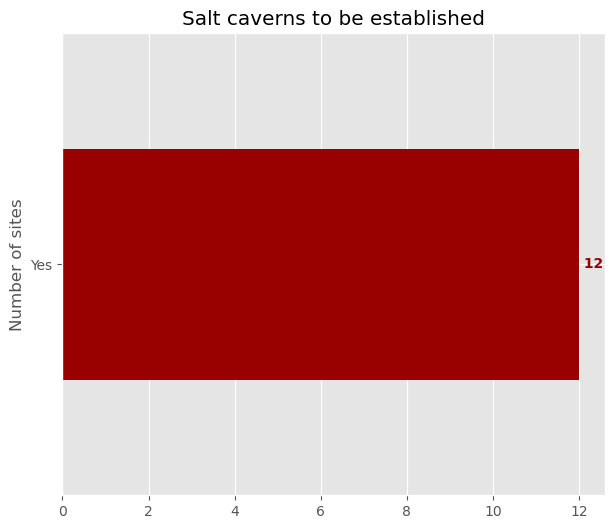

In [25]:
colors = ['#990000', '#0059b3']

salt_df.build_salt.value_counts().plot.barh(
  title='Salt caverns to be established', xlabel='Number of sites', color=colors, ylabel='Establish', figsize=(7,6)) 

for i, v in enumerate(salt_df.build_salt.value_counts()):
    plt.text(v, i, ' '+str(round(v,3)), color=colors[i], va='center', fontweight='bold')


In [26]:
# Create dataframe column to store whether to build the warehouse or not
facility_df['build_warehouse'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in facility_df['warehouse_id']:
    if created_facility[i].X == 1:
        print('Build site at: ', i)
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'Yes'
    else:
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'No'

Build site at:  Warehouse 1
Build site at:  Warehouse 2
Build site at:  Warehouse 4
Build site at:  Warehouse 7
Build site at:  Warehouse 10
Build site at:  Warehouse 13
Build site at:  Warehouse 18
Build site at:  Warehouse 20
Build site at:  Warehouse 31
Build site at:  Warehouse 32
Build site at:  Warehouse 34
Build site at:  Warehouse 39
Build site at:  Warehouse 40
Build site at:  Warehouse 48
Build site at:  Warehouse 50
Build site at:  Warehouse 54
Build site at:  Warehouse 55
Build site at:  Warehouse 57
Build site at:  Warehouse 59
Build site at:  Warehouse 60
Build site at:  Warehouse 61
Build site at:  Warehouse 62
Build site at:  Warehouse 63
Build site at:  Warehouse 65
Build site at:  Warehouse 67
Build site at:  Warehouse 68
Build site at:  Warehouse 70
Build site at:  Warehouse 71
Build site at:  Warehouse 73
Build site at:  Warehouse 75
Build site at:  Warehouse 85
Build site at:  Warehouse 88
Build site at:  Warehouse 89
Build site at:  Warehouse 91
Build site at:  Wa

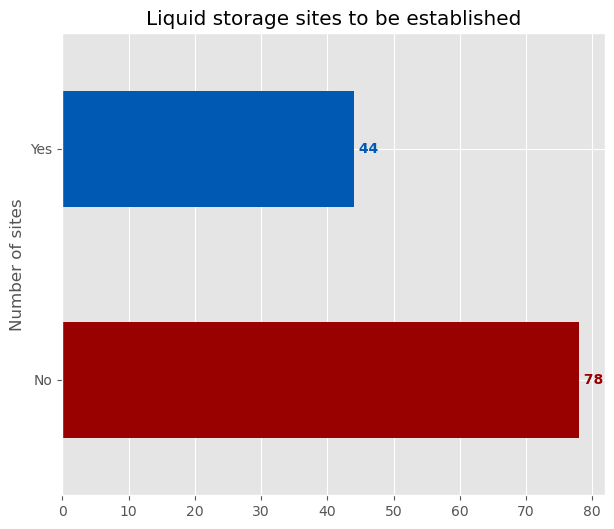

In [27]:
colors = ['#990000', '#0059b3']

facility_df.build_warehouse.value_counts().plot.barh(
  title='Liquid storage sites to be established', xlabel='Number of sites', color=colors, ylabel='Establish', figsize=(7,6)) 

for i, v in enumerate(facility_df.build_warehouse.value_counts()):
    plt.text(v, i, ' '+str(round(v,3)), color=colors[i], va='center', fontweight='bold')


C:\Users\Syrine Frini\anaconda3\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


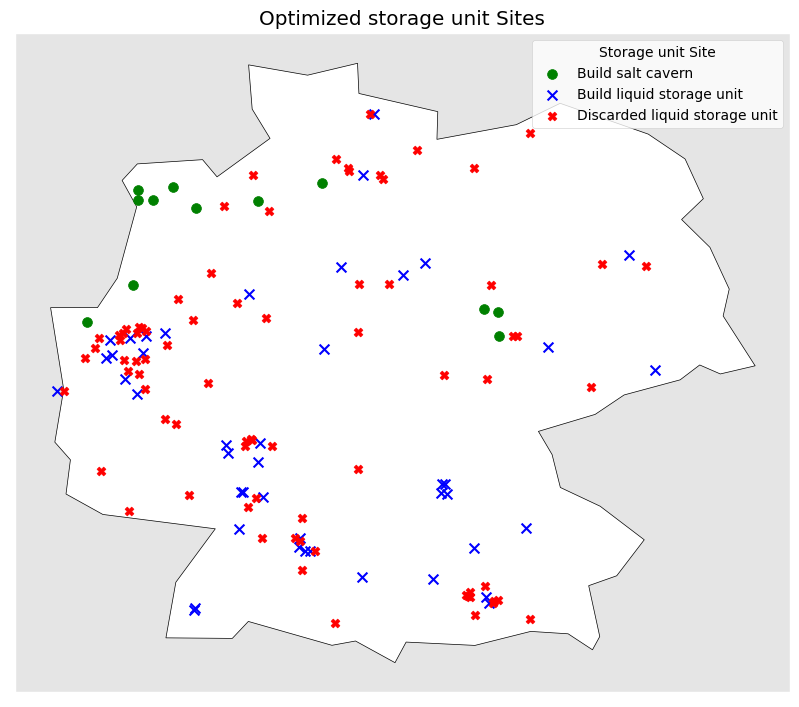

In [28]:
# Plot the shape of germany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot sites to establish
salt_df.\
    loc[salt_df.build_salt =='Yes'].\
    plot(ax=ax, marker='o', c='green', markersize=50, label='Build salt cavern')

# Plot sites to discard
salt_df.\
    loc[salt_df.build_salt =='No'].\
    plot(ax=ax, marker='o', c='red', markersize=40, label='Discarded salt cavern')


# Plot sites to establish
facility_df.\
    loc[facility_df.build_warehouse =='Yes'].\
    plot(ax=ax, marker='x', c='blue', markersize=50, label='Build liquid storage unit')

# Plot sites to discard
facility_df.\
    loc[facility_df.build_warehouse =='No'].\
    plot(ax=ax, marker='X', c='red', markersize=40, label='Discarded liquid storage unit')
# Add title
plt.title('Optimized storage unit Sites')

# Add legend
plt.legend(title='Storage unit Site', facecolor='white')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])


# Show plot
plt.show()

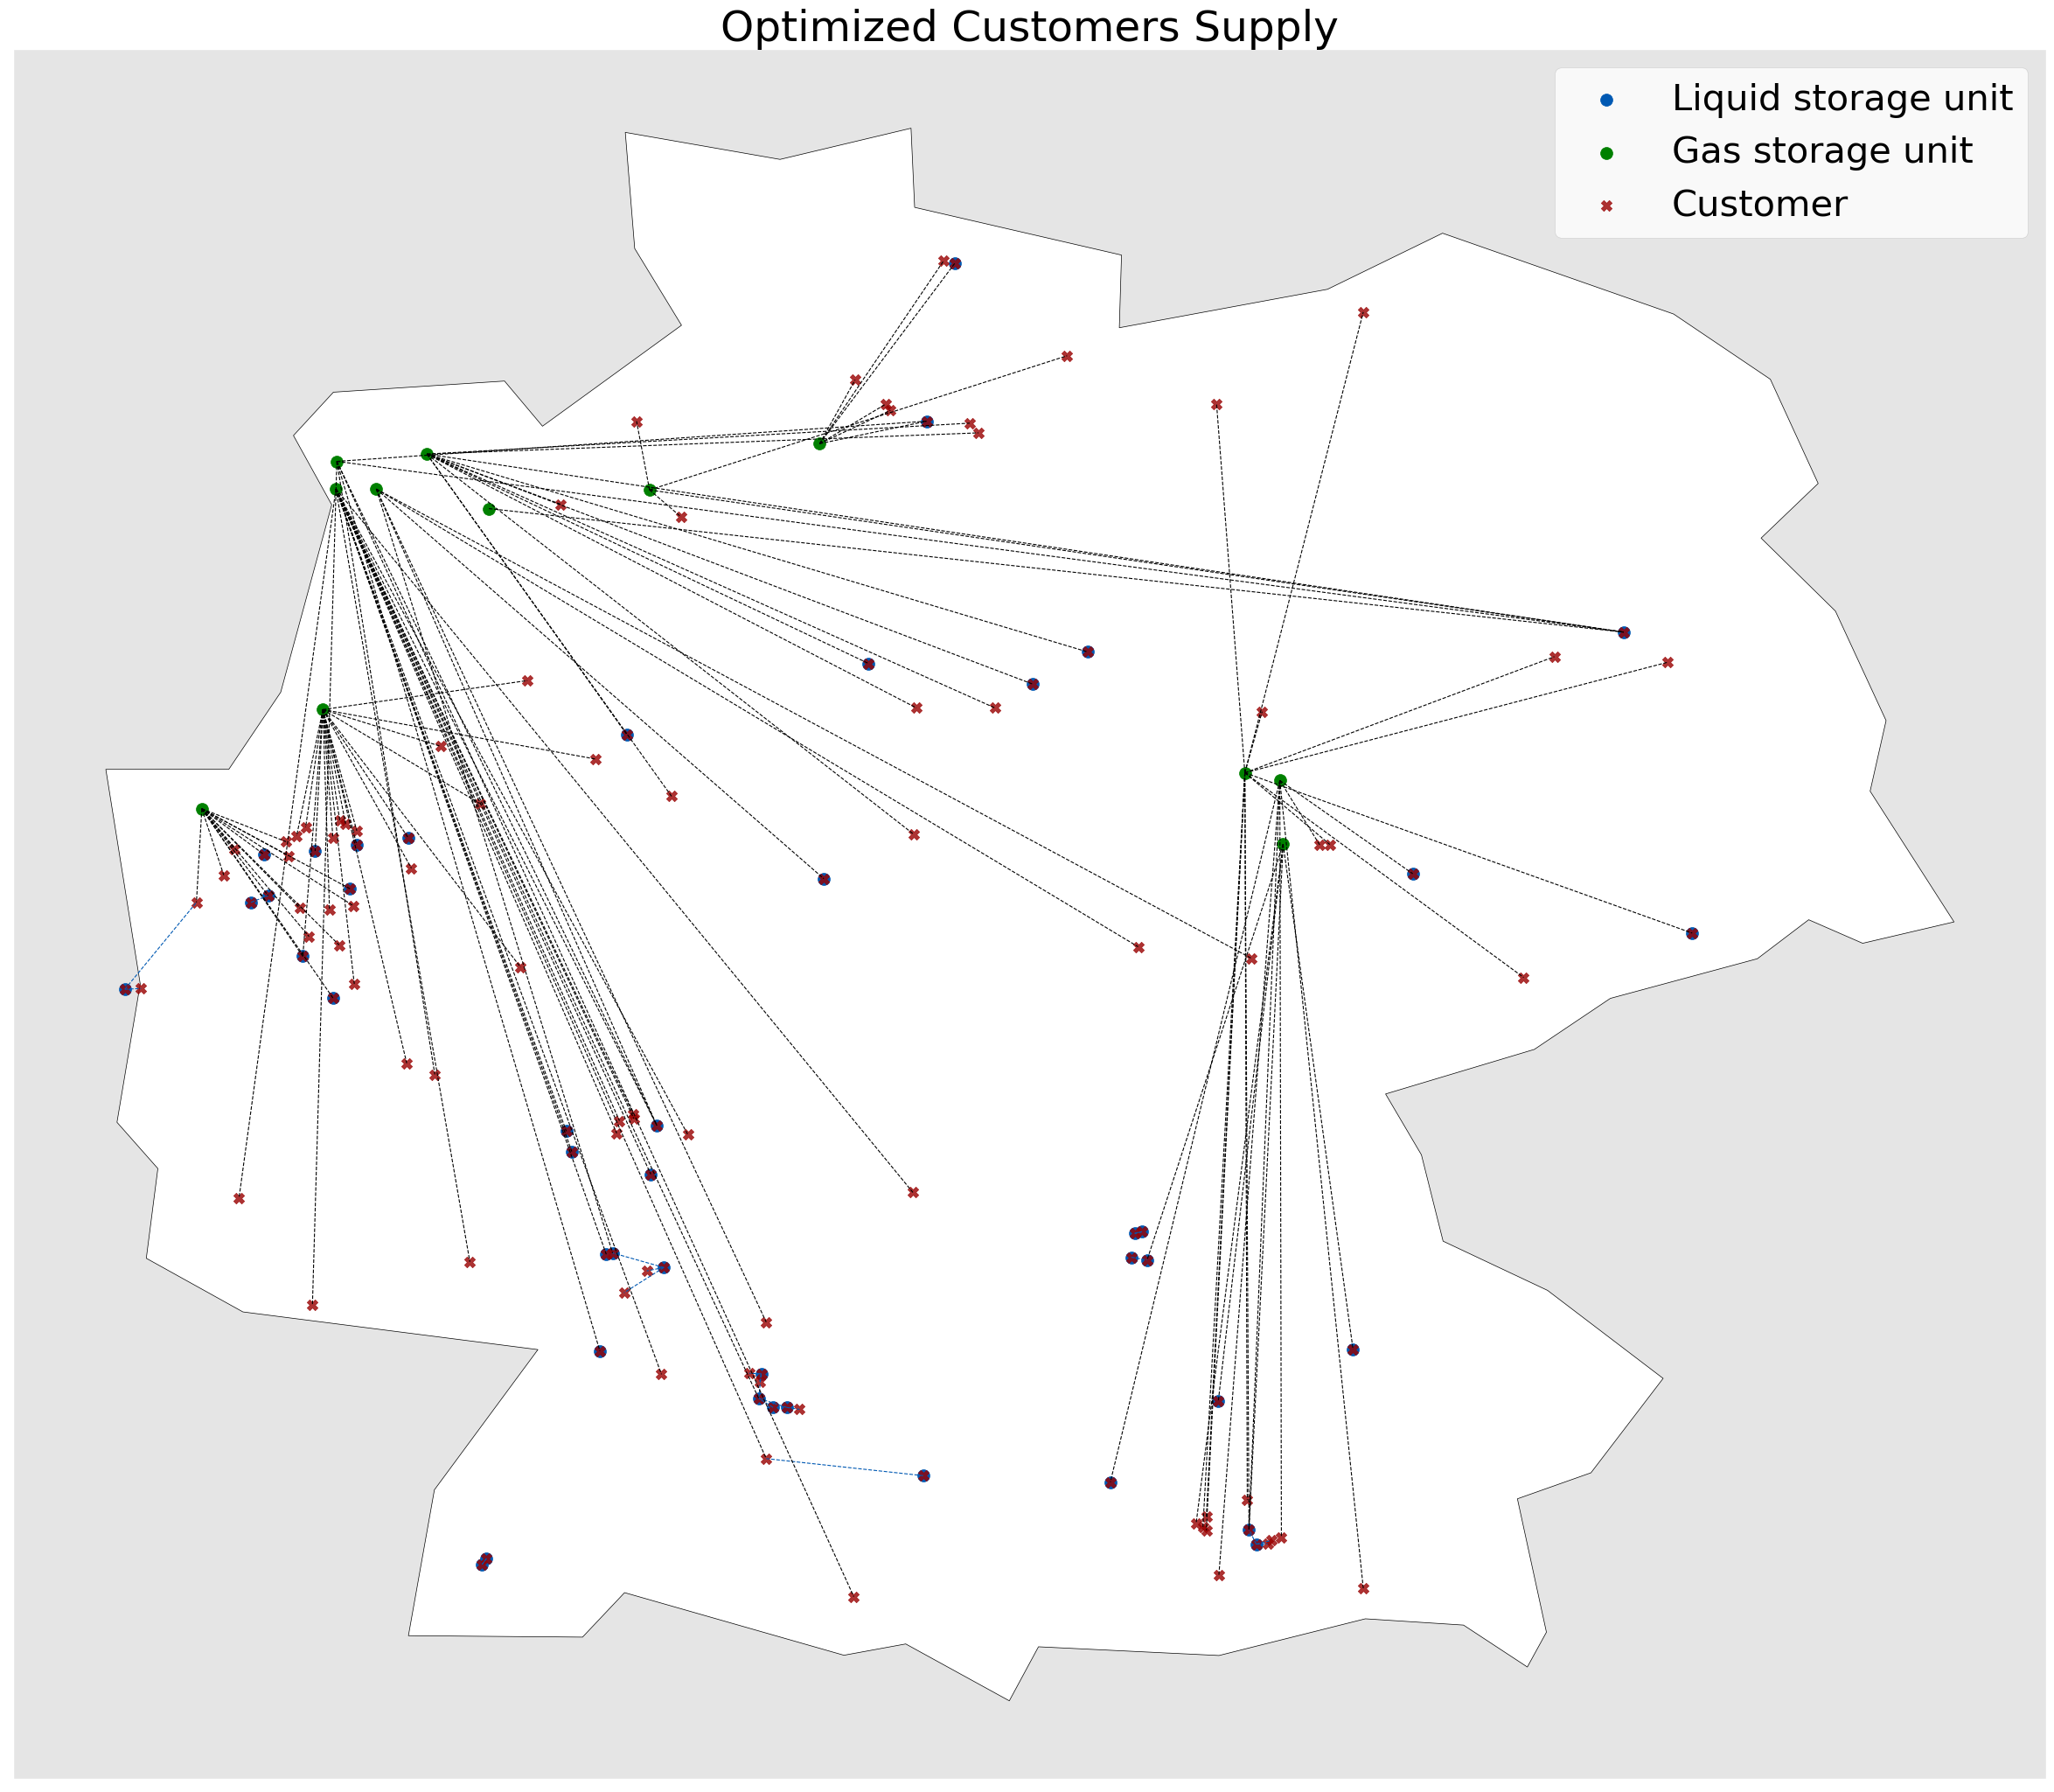

In [29]:
def get_linked_customers(input_warehouse, served_customer):
    '''
    Find customer ids that are served by the input warehouse.

    Args:
        - input_warehouse: string (example: <Warehouse 21>)
    Out:
        - List of customers ids connected to the warehouse
    '''
    # Initialize empty 
    linked_customers = []

    # Iterate through the xij decision variable
    for (i, j) in served_customer.keys():
        # Filter the input warehouse and positive variable values
        if j == input_warehouse and served_customer[(i, j)].X > 0:
            # Customer is served by the input warehouse
            linked_customers.append(i)

    return linked_customers


# Warehouses and salt cavern to establish
establish_facility = facility_df.loc[facility_df['build_warehouse'] == 'Yes']
establish_salt = salt_df.loc[salt_df['build_salt'] == 'Yes']

# Plot the shape of germany
ax = germany.plot(color='white', edgecolor='black', figsize=(30, 30))

# Plot sites to establish
establish_facility.plot(ax=ax, marker='o', c='#0059b3', markersize=100, label='Liquid storage unit')
establish_salt.plot(ax=ax, marker='o', c='green', markersize=100, label='Gas storage unit')


# Plot customers
customer_df.plot(ax=ax, marker='X', color='#990000', markersize=80, alpha=0.8, label='Customer')

# For each warehouse to build
for w in establish_facility['warehouse_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w, served_customer_facility)

    # For each served customer
    for c in linked_customers:
        # Plot connection between warehouse and the served customer
        ax.plot(
            [establish_facility.loc[establish_facility['warehouse_id'] == w, 'lng'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lng'].values[0]],
            [establish_facility.loc[establish_facility['warehouse_id'] == w, 'lat'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lat'].values[0]],
            linewidth=0.8, linestyle='--', color='#0059b3')
        
for w in establish_salt['salt_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w, served_customer_salt)

    # For each served customer
    for c in linked_customers:
        # Plot connection between warehouse and the served customer
        ax.plot(
            [establish_salt.loc[establish_salt['salt_id'] == w, 'lng'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lng'].values[0]],
            [establish_salt.loc[establish_salt['salt_id'] == w, 'lat'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lat'].values[0]],
            linewidth=0.8, linestyle='--', color='black')

# Add title
plt.title('Optimized Customers Supply', fontsize=35)

# Add legend
plt.legend(facecolor='white', fontsize=30)

# Remove ticks from axis
plt.xticks([])
plt.yticks([])


# Show plot
plt.show()

C:\Users\Syrine Frini\anaconda3\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


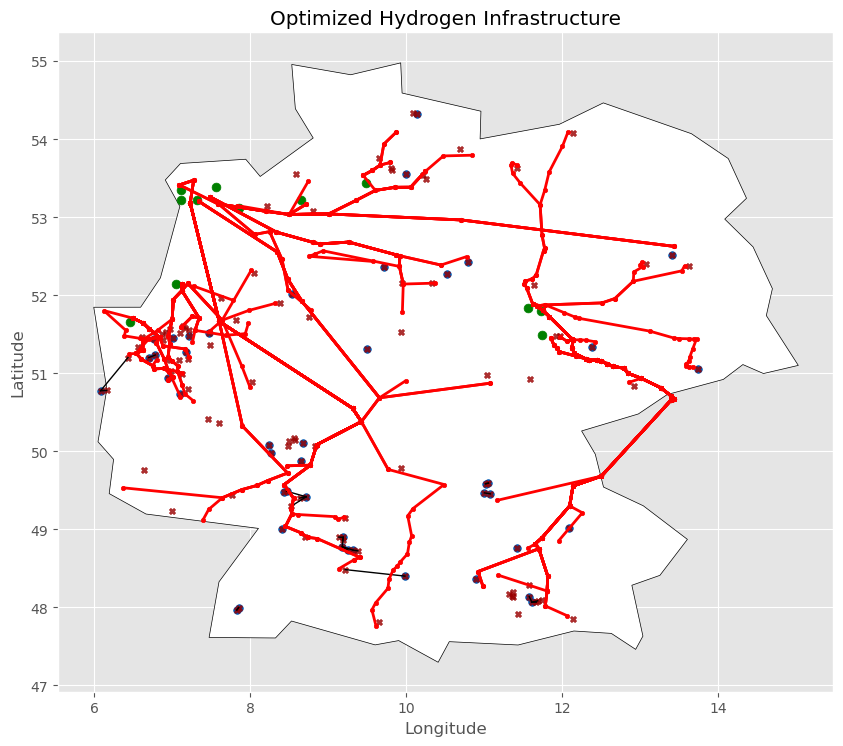

In [30]:
import geopandas as gpd
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the graph and nodes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'] == 'Germany']
germany.plot(ax=ax, color='white', edgecolor='black')


# Plot sites to establish
establish_facility.plot(ax=ax, marker='o', c='#0059b3', markersize=30, label='Storage unit')
establish_salt.plot(ax=ax, marker='o', c='green', markersize=40, label='Salt cavern')
customer_df.plot(ax=ax, marker='X', color='#990000', markersize=20, alpha=0.8, label='Customer')


# For each warehouse to build
for w in establish_facility['warehouse_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w, served_customer_facility)

    # For each served customer
    for c in linked_customers:
        # Plot connection between warehouse and the served customer
        ax.plot(
            [establish_facility.loc[establish_facility['warehouse_id'] == w, 'lng'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lng'].values[0]],
            [establish_facility.loc[establish_facility['warehouse_id'] == w, 'lat'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lat'].values[0]],
            linewidth=1, color='black')
            # Plot customers


for w in establish_salt['salt_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w, served_customer_salt)

    # For each served customer
    for c in linked_customers:
        closest_node1 = find_city_location(establish_salt.loc[establish_salt['salt_id'] == w, 'city'].values[0], salt_df)
        closest_node2 = find_city_location(customer_df.loc[customer_df['customer_id'] == c, 'city'].values[0], customer_df)

        shortest_path = nx.shortest_path(G, closest_node1, closest_node2, weight='distance')

        # Create a GeoDataFrame for the shortest path nodes
        path_nodes_data = []
        for node in shortest_path:
            geometry = nodes_gdf.loc[node, 'geometry']
            path_nodes_data.append({'geometry': geometry})

        path_nodes_gdf = gpd.GeoDataFrame(path_nodes_data)

        # Create a GeoDataFrame for the shortest path
        path_data = []
        path_lines = []
        for i in range(len(shortest_path) - 1):
            u = shortest_path[i]
            v = shortest_path[i + 1]
            data = G.edges[u, v]
            source = nodes_gdf.loc[u, 'geometry']
            target = nodes_gdf.loc[v, 'geometry']
            line = LineString([source, target])
            path_lines.append(line)
            path_data.append((u, v, data['distance']))

        path_df = pd.DataFrame(path_data, columns=['source', 'target', 'distance'])
        path_gdf = gpd.GeoDataFrame(path_df, geometry=path_lines)

        # Plot the shortest path nodes and path
        path_nodes_gdf.plot(ax=ax, color='red', markersize=10)
        path_gdf.plot(ax=ax, color='red', linewidth=2)



plt.title('Optimized Hydrogen Infrastructure')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
